In [6]:
import sys
from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from IPython.display import HTML, display
from matplotlib import cm
from matplotlib.colors import ListedColormap

try:
    from sklearnex import patch_sklearn
except ImportError:
    %pip install scikit-learn-intelex
    from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import joblib

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [7]:
# Load the RawDataFrames
train_features_file = Path("data/train_features.parquet")
if train_features_file.exists:
    raw_train_df = pl.read_parquet(train_features_file, memory_map=True)
else:
    print(f"Train Features File is missing {train_features_file}", file=sys.stderr)
    exit()

test_features_file = Path("data/test_features.parquet")
if test_features_file.exists:
    test_df = pl.read_parquet(test_features_file, memory_map=True)
else:
    print(f"Test Features File is missing {test_features_file}", file=sys.stderr)
    exit()

meta_file = Path("data/meta_full.parquet")
if meta_file.exists:
    meta_df = pl.read_parquet(meta_file, memory_map=True)
else:
    print(f"Meta File is missing {meta_file}", file=sys.stderr)
    exit()

In [8]:
## Our Dataset is unbalanced, so we need to balance it
## We will do this by sampling the same number of samples per class
## We will use 210 samples per class, because that is the number of samples in the smallest class
## We will use a random seed of 42, so we can reproduce the results
## We will use a fraction of 1, so we can shuffle the data
## We will use a train percentage of 80%, so we can use the remaining 20% for validation
## We were provided a test dataset in the data so there's no need to provision one here
samples_per_class = 210
random_seed = 42
pl.set_random_seed(random_seed)
train_equal_sample_df = pl.concat(
    [
        x.sample(samples_per_class, with_replacement=False, shuffle=False)
        for x in raw_train_df.partition_by("ClassId")
    ]
)
train_equal_shuffled = train_equal_sample_df.sample(shuffle=True, fraction=1)
train_percentage = 0.8
num_train_rows = int(train_equal_shuffled.height * train_percentage)

train_df = train_equal_shuffled.slice(0, num_train_rows)
validation_df = train_equal_shuffled.slice(num_train_rows, train_equal_shuffled.height)

# Check we have preserved the distribution
# train_df.group_by('ClassId').agg(pl.col('ClassId').count().alias('Count')).sort('ClassId')
# validation_df.group_by('ClassId').agg(pl.col('ClassId').count().alias('Count')).sort('ClassId')

del raw_train_df, train_equal_sample_df, train_equal_shuffled

In [9]:
### HOG Features

X_train_HOG = np.asarray(train_df["HOG_Features"].to_list())
X_test_HOG = np.asarray(test_df["HOG_Features"].to_list())
X_validation_HOG = np.asarray(validation_df["HOG_Features"].to_list())

In [10]:
X_train = X_train_HOG
X_test = X_test_HOG
X_validation = X_validation_HOG

In [11]:
y_train = train_df["ClassId"].to_numpy()
y_test = test_df["ClassId"].to_numpy()
y_validation = validation_df["ClassId"].to_numpy()

In [12]:
# Linear Kernels seem to work very well for our data
joblib_file = Path("svc_linear_hog_only_classifier.joblib")
if not joblib_file.exists():
    # These parameters wer obtained with GridSearchCV which is currently disabled since it takes over an hour to run
    # We will use a linear kernel, because it seems to work very well for our data
    # We will use a C value of 0.1, because it seems to work very well for our data
    # We will use a one-vs-one decision function, because it seems to work very well for our data
    # We will use a probability function, because it seems to work very well for our data
    # We will use a random state of 42, so we can reproduce the results
    svc_model = make_pipeline(
        StandardScaler(),
        SVC(
            kernel="linear",
            C=0.01,
            decision_function_shape="ovo",
            probability=True,
            random_state=42,
        ),
    )
    svc_model.fit(X_train, y_train)
    joblib.dump(svc_model, joblib_file)
else:
    svc_model = joblib.load(joblib_file)
hyperparameters = svc_model.get_params()
print("Best Hyperparameters using get_params():")
print(hyperparameters)

Best Hyperparameters using get_params():
{'memory': None, 'steps': [('standardscaler', StandardScaler()), ('svc', SVC(C=0.01, decision_function_shape='ovo', kernel='linear', probability=True,
    random_state=42))], 'verbose': False, 'standardscaler': StandardScaler(), 'svc': SVC(C=0.01, decision_function_shape='ovo', kernel='linear', probability=True,
    random_state=42), 'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'svc__C': 0.01, 'svc__break_ties': False, 'svc__cache_size': 200, 'svc__class_weight': None, 'svc__coef0': 0.0, 'svc__decision_function_shape': 'ovo', 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'linear', 'svc__max_iter': -1, 'svc__probability': True, 'svc__random_state': 42, 'svc__shrinking': True, 'svc__tol': 0.001, 'svc__verbose': False}


In [13]:
y_pred = svc_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy on Test Set:", accuracy)

ValueError: X has 2916 features, but StandardScaler is expecting 10931 features as input.

In [9]:
confusion_matrix_result = confusion_matrix(y_test, y_pred)

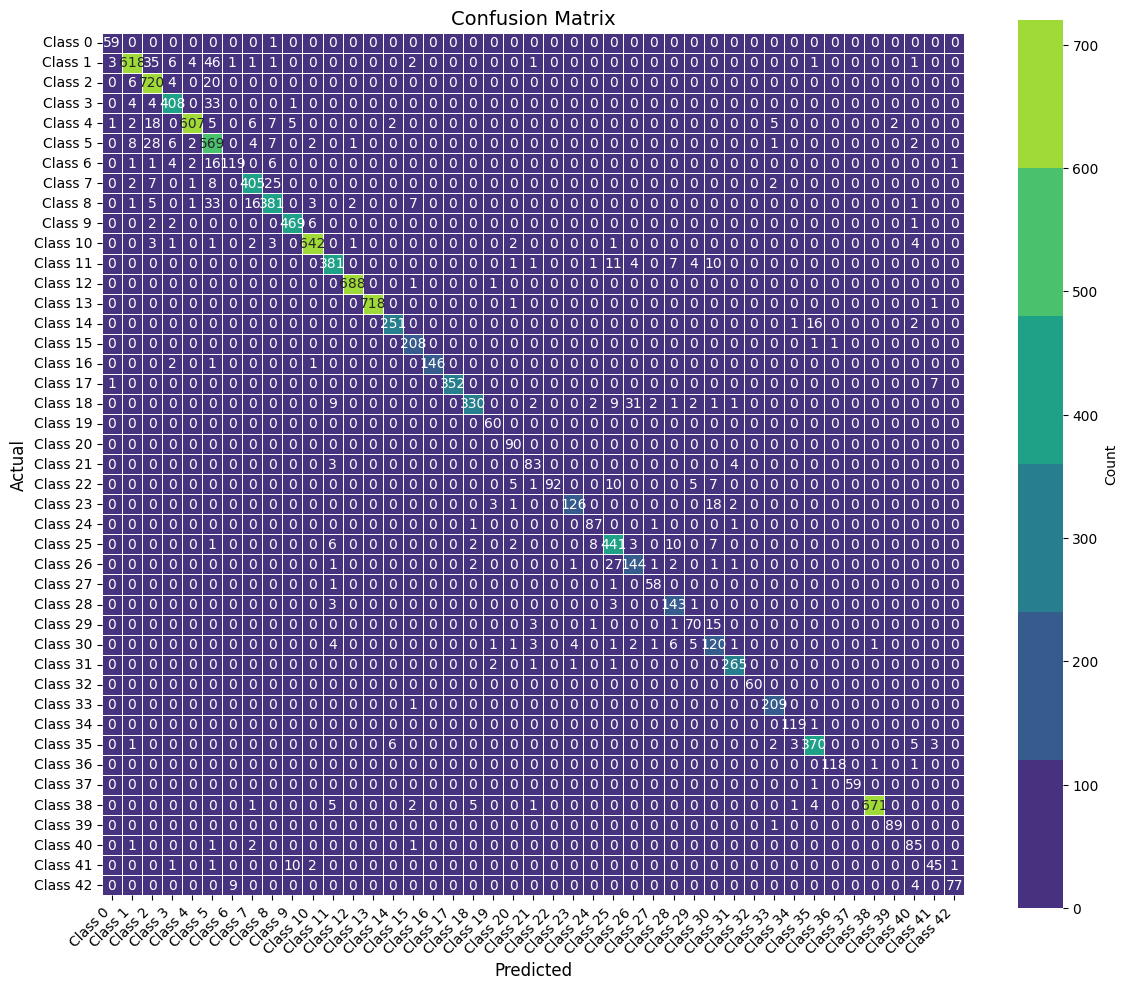

In [10]:
# Create a heatmap for the confusion matrix
plt.figure(figsize=(12, 10))

class_labels = [f"Class {i}" for i in range(43)]

# Use seaborn's heatmap with a diverging color palette
cmap = ListedColormap(sns.color_palette("viridis"))
sns.heatmap(
    confusion_matrix_result,
    annot=True,
    fmt="d",
    cmap=cmap,
    linewidths=0.5,
    square=True,
    cbar_kws={"label": "Count"},
    xticklabels=class_labels,
    yticklabels=class_labels,
    annot_kws={"size": 10},
)

# Customize labels and title
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Adjust layout to prevent cutoff of labels
plt.tight_layout()

# Show the plot
plt.show()

In [11]:
report = classification_report(y_test, y_pred)


def display_classification_report(report):
    report_html = HTML(f"<pre>{report}</pre>")
    display(report_html)


# Display the formatted classification report
display_classification_report(report)

In [12]:
misclassified_indices = np.where(y_test != y_pred)[0]

confused_counts = {}
confused_index_dict = {}
for i in misclassified_indices:
    true_label = y_test[i]
    predicted_label = y_pred[i]

    # Use a tuple to represent the pair of true and predicted labels
    label_pair = (true_label, predicted_label)

    # Increment the count for the label pair
    confused_counts[label_pair] = confused_counts.get(label_pair, 0) + 1
    if label_pair not in confused_index_dict:
        confused_index_dict[label_pair] = []
    confused_index_dict[label_pair].append(int(i))

# Print the top 10 most confused items and their counts
top_10_confused_counts = sorted(
    confused_counts.items(), key=lambda x: x[1], reverse=True
)[:20]

for label_pair, count in top_10_confused_counts:
    true_label, predicted_label = label_pair
    print(
        f"True Label: {true_label:2d},\tPredicted Label: {predicted_label:2d},\tCount: {count:2d}"
    )

True Label:  1,	Predicted Label:  5,	Count: 46
True Label:  1,	Predicted Label:  2,	Count: 35
True Label:  8,	Predicted Label:  5,	Count: 33
True Label:  3,	Predicted Label:  5,	Count: 33
True Label: 18,	Predicted Label: 26,	Count: 31
True Label:  5,	Predicted Label:  2,	Count: 28
True Label: 26,	Predicted Label: 25,	Count: 27
True Label:  7,	Predicted Label:  8,	Count: 25
True Label:  2,	Predicted Label:  5,	Count: 20
True Label: 23,	Predicted Label: 30,	Count: 18
True Label:  4,	Predicted Label:  2,	Count: 18
True Label:  6,	Predicted Label:  5,	Count: 16
True Label:  8,	Predicted Label:  7,	Count: 16
True Label: 14,	Predicted Label: 35,	Count: 16
True Label: 29,	Predicted Label: 30,	Count: 15
True Label: 11,	Predicted Label: 25,	Count: 11
True Label: 41,	Predicted Label:  9,	Count: 10
True Label: 25,	Predicted Label: 28,	Count: 10
True Label: 11,	Predicted Label: 30,	Count: 10
True Label: 22,	Predicted Label: 25,	Count: 10


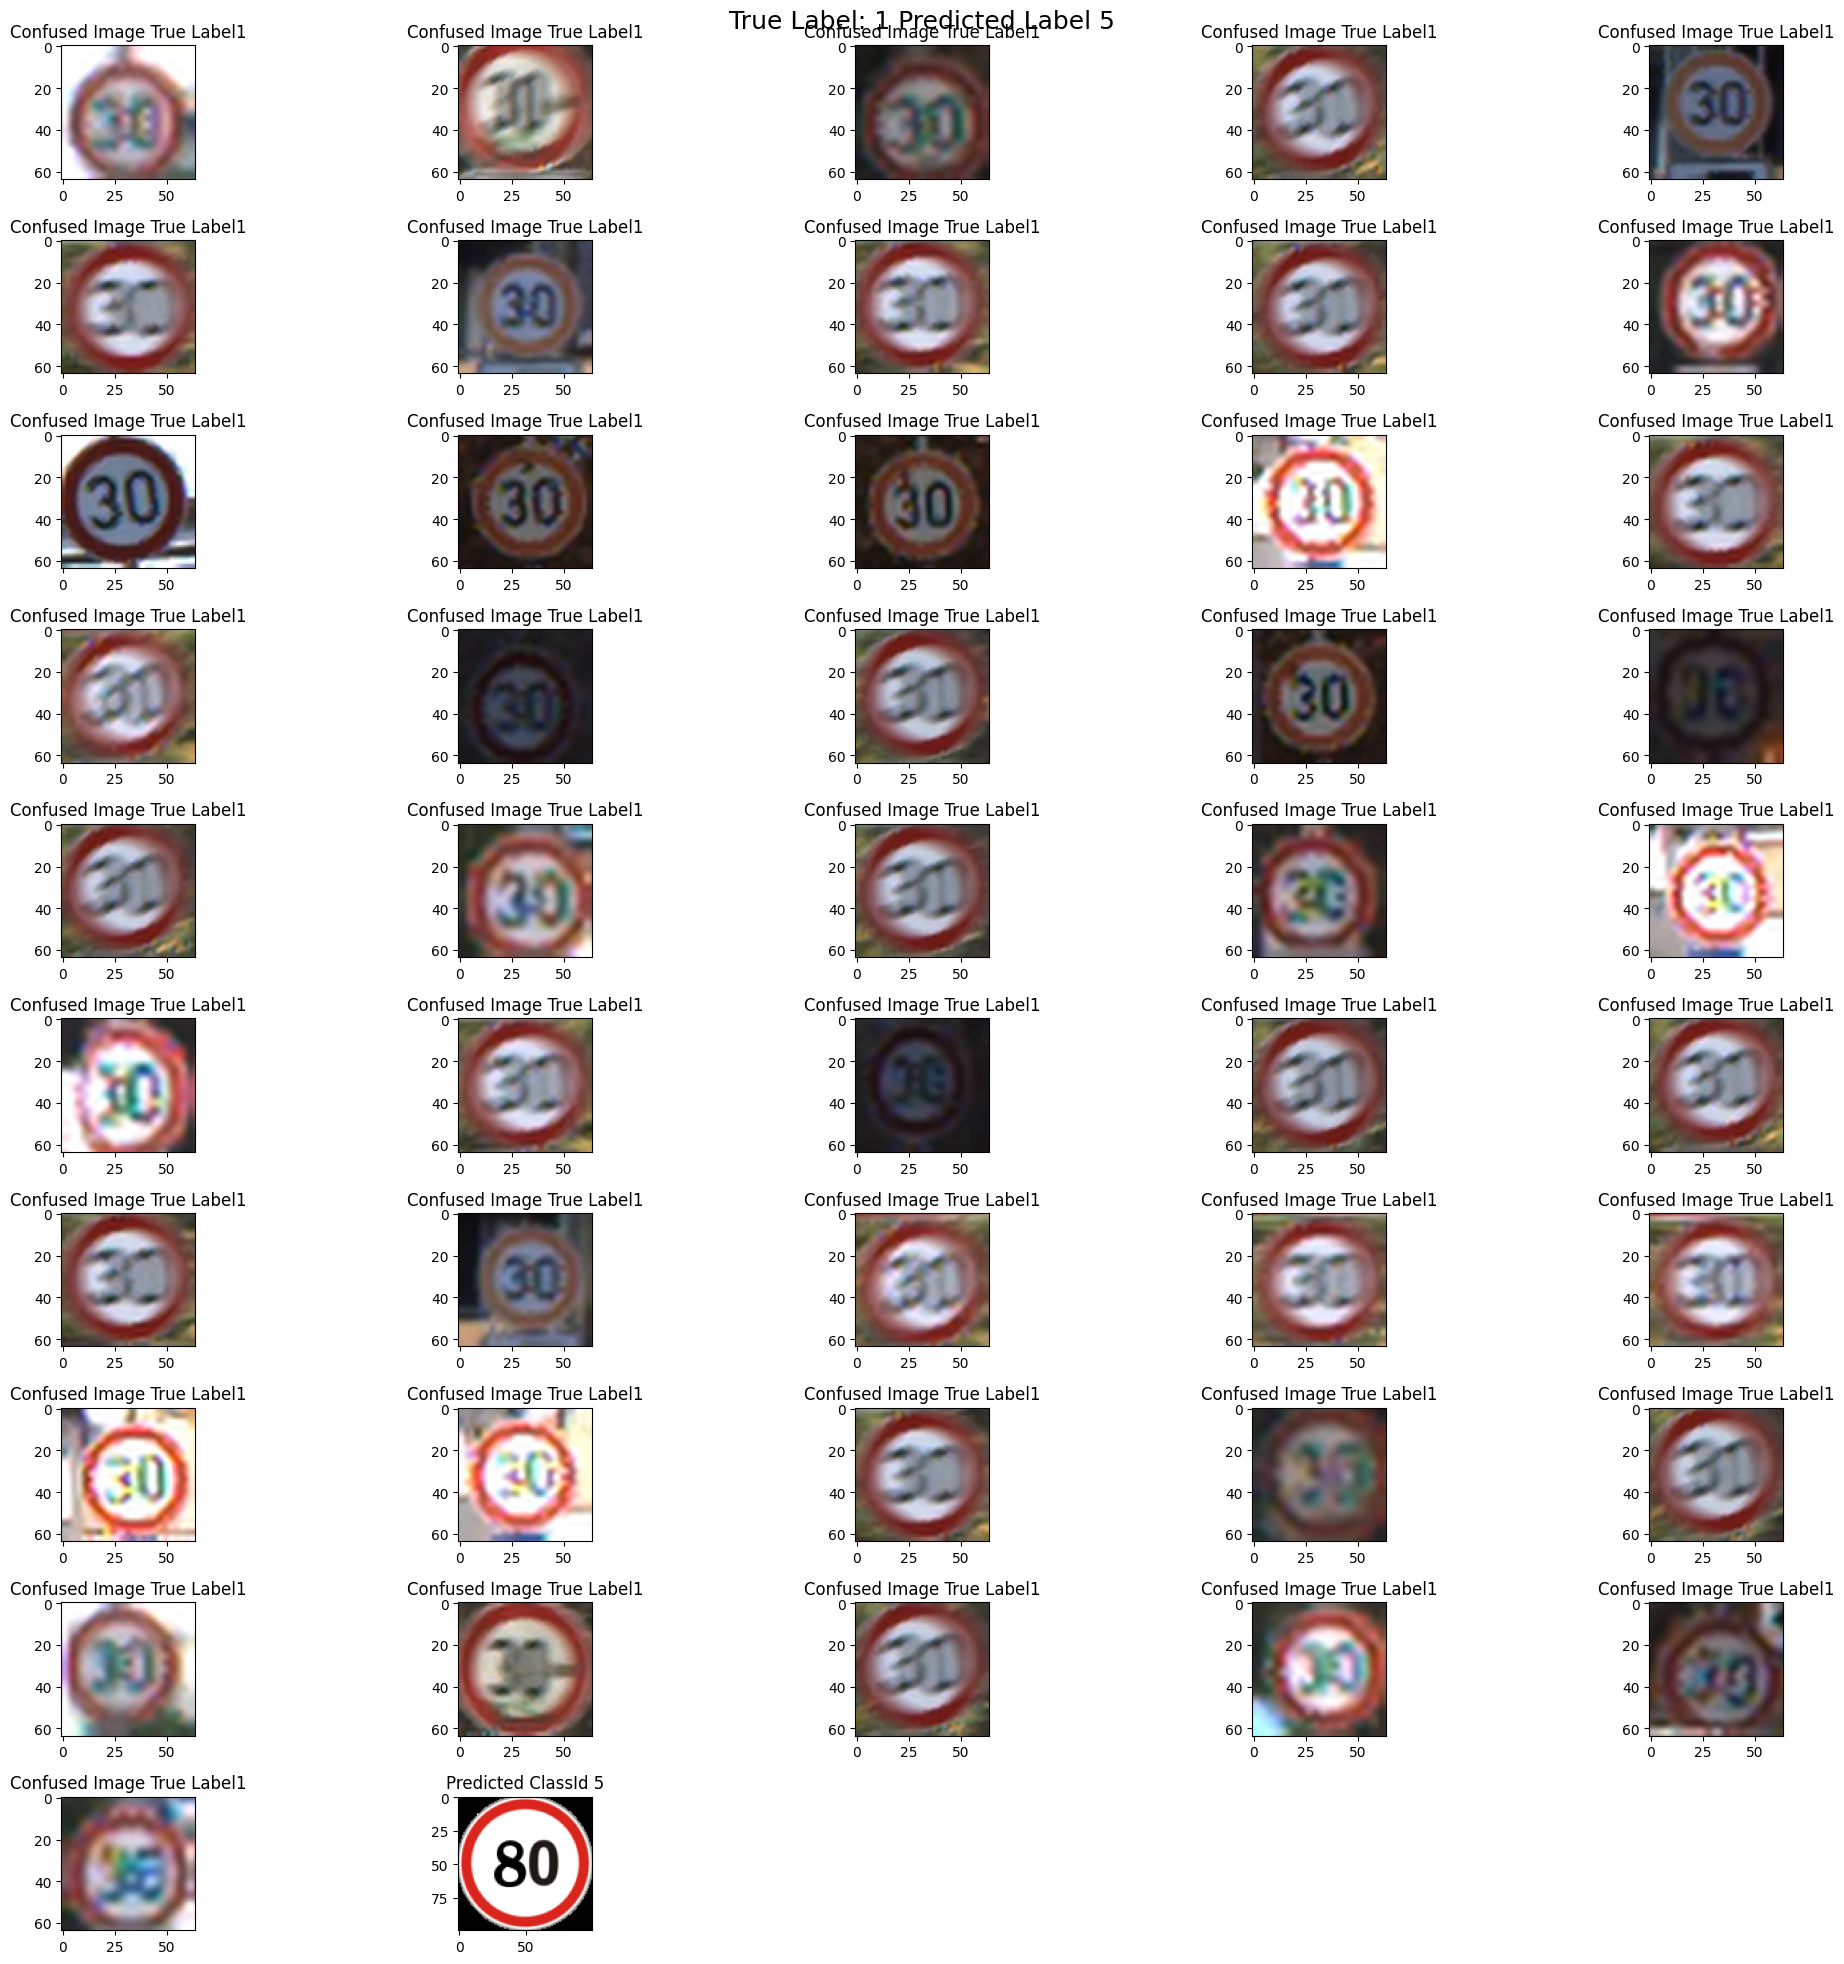

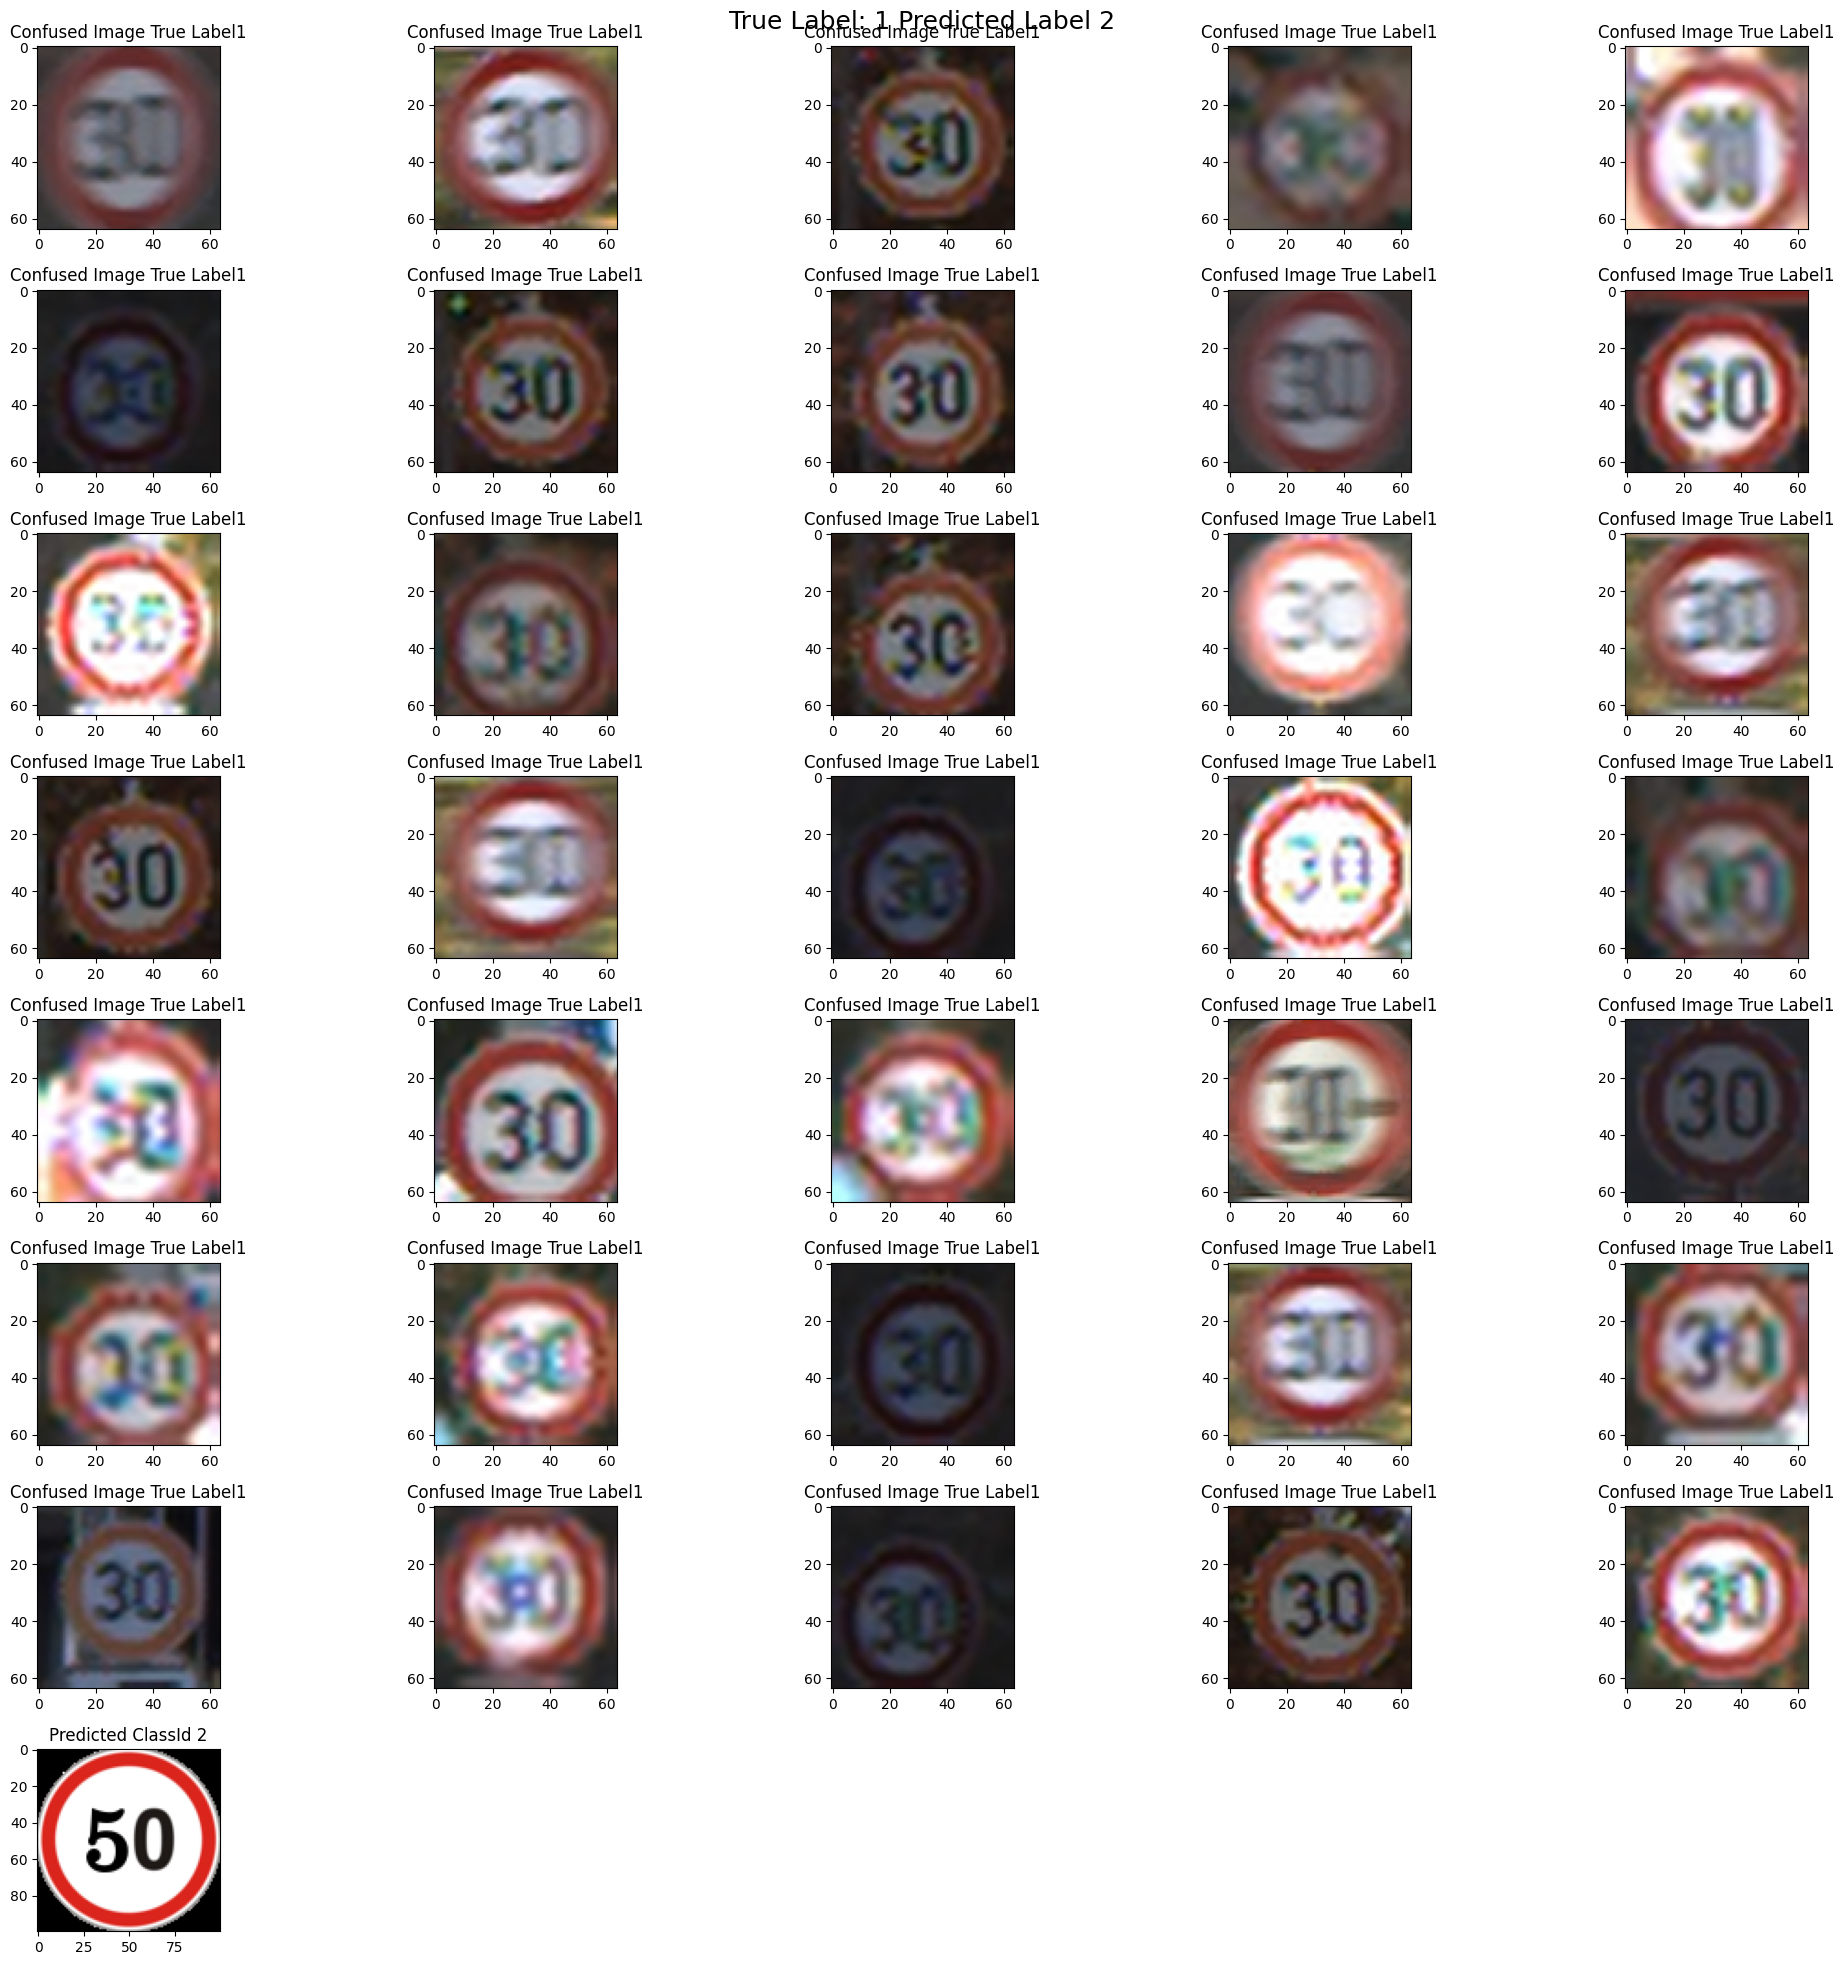

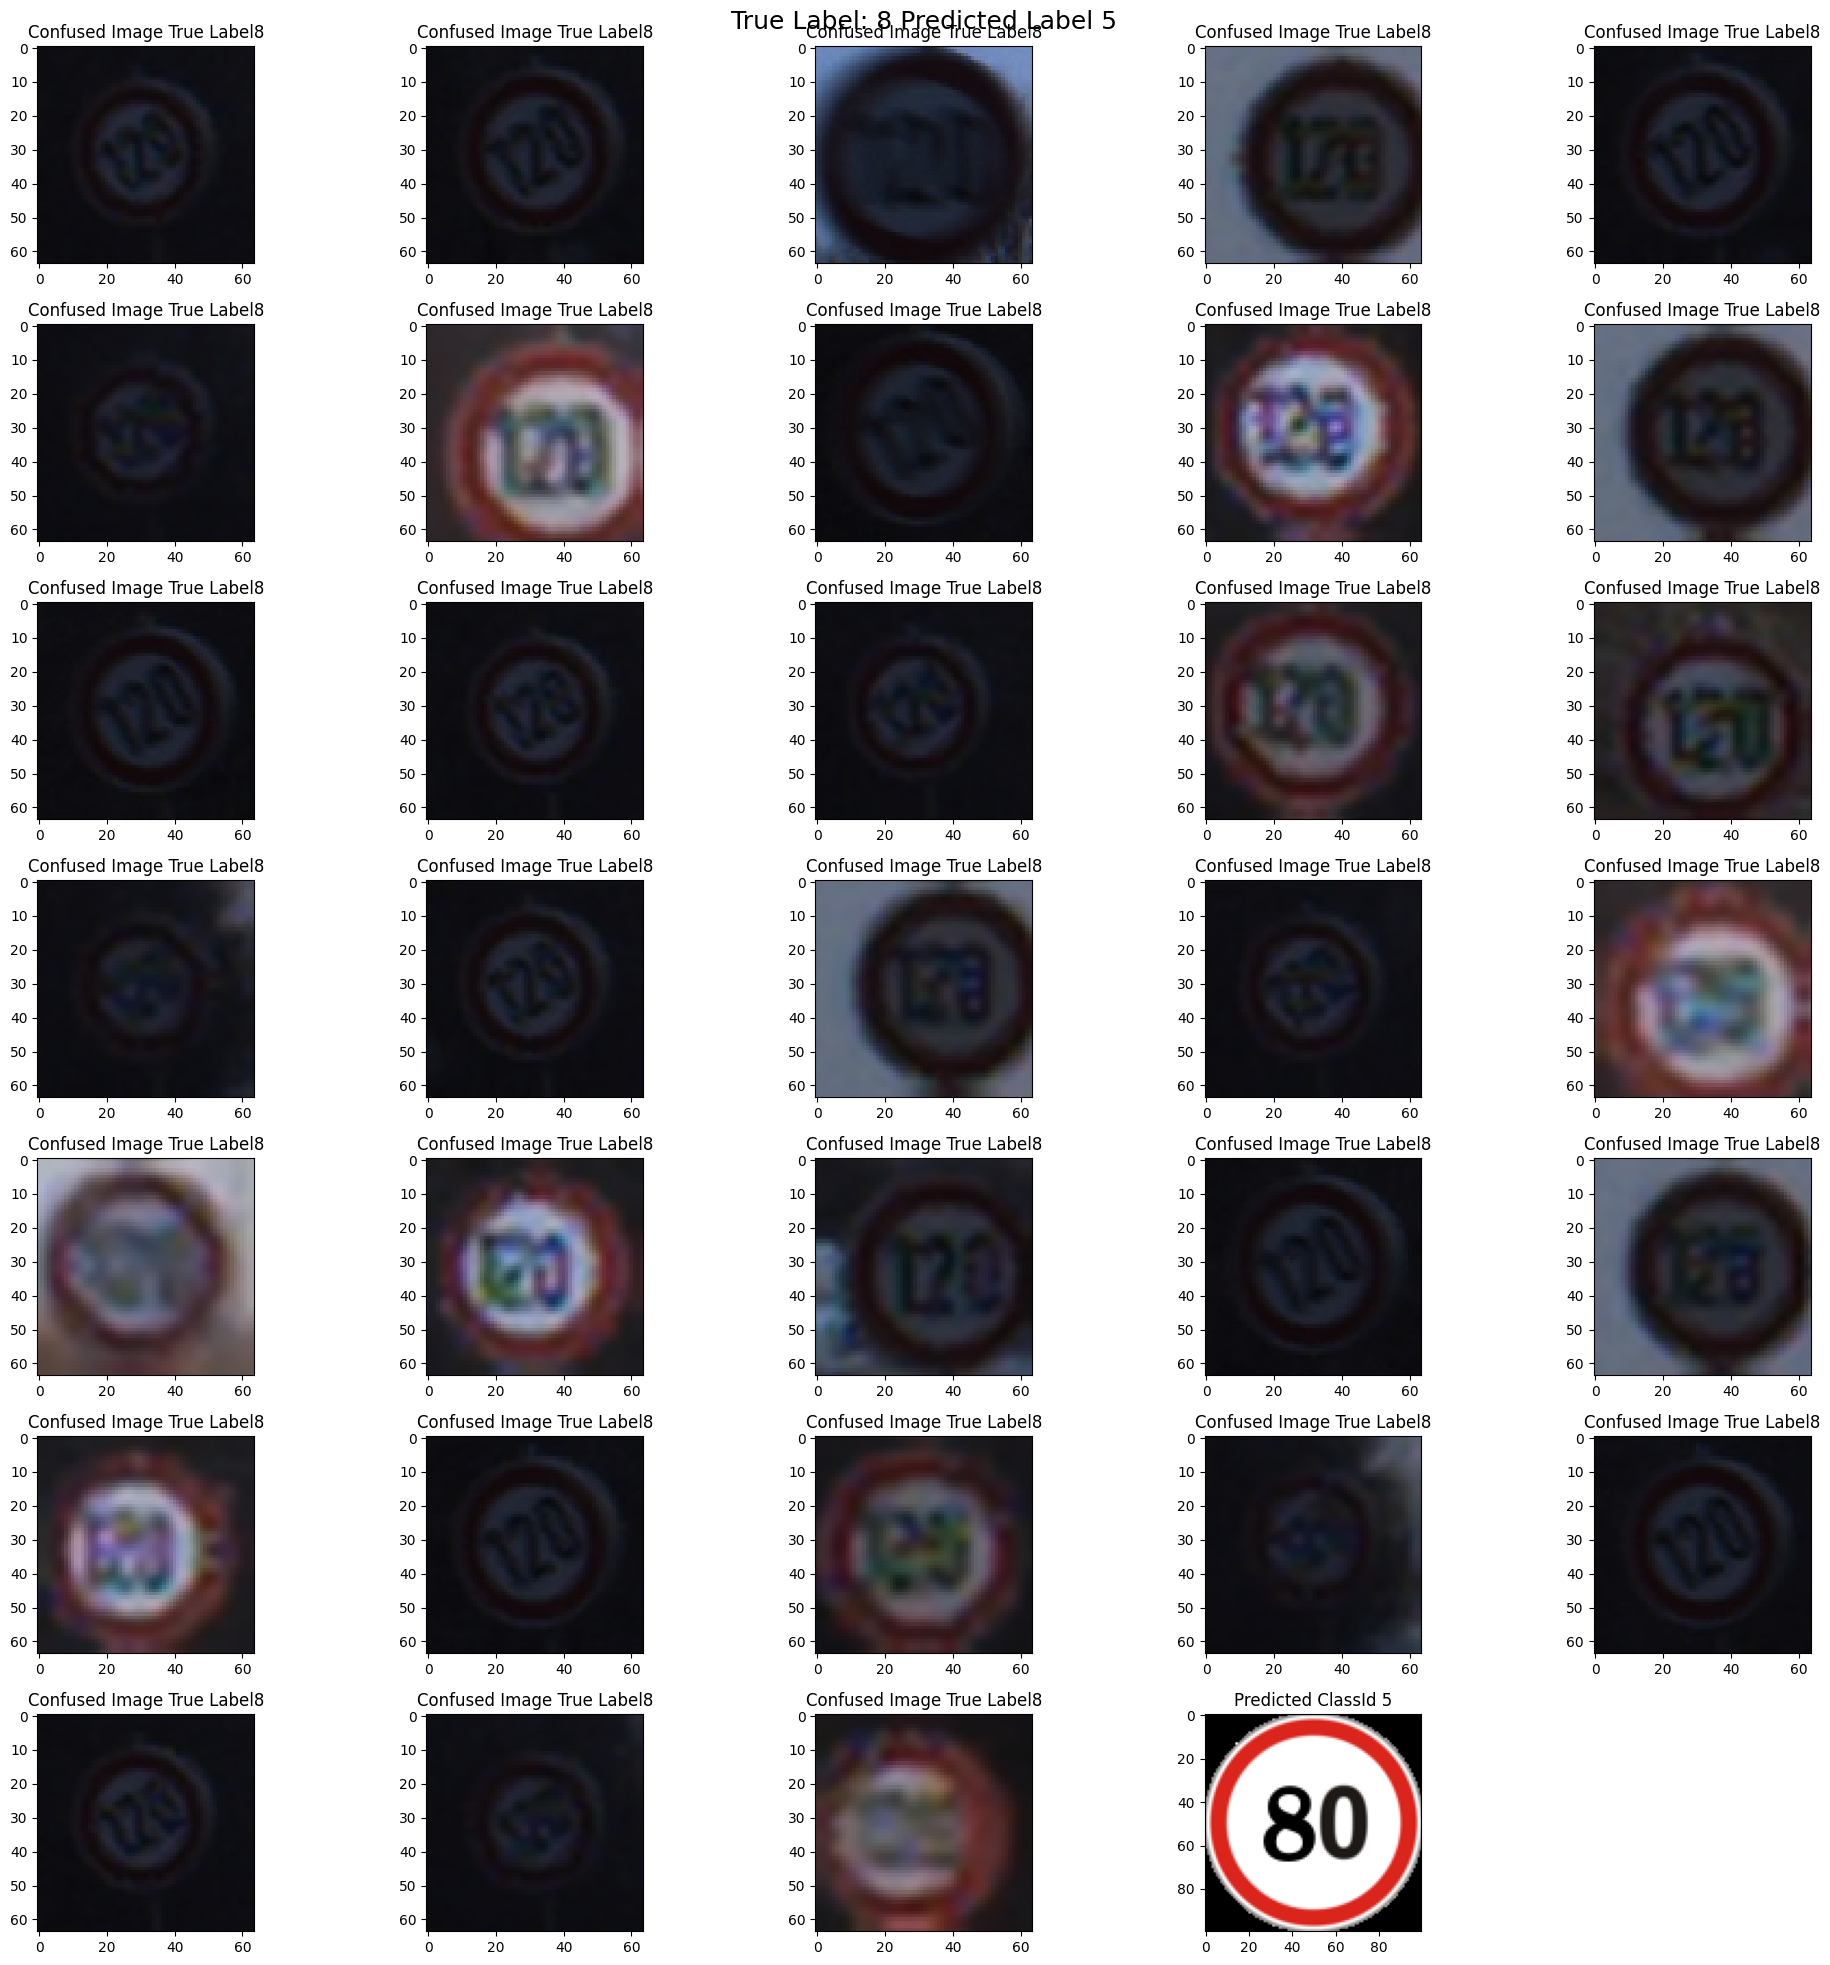

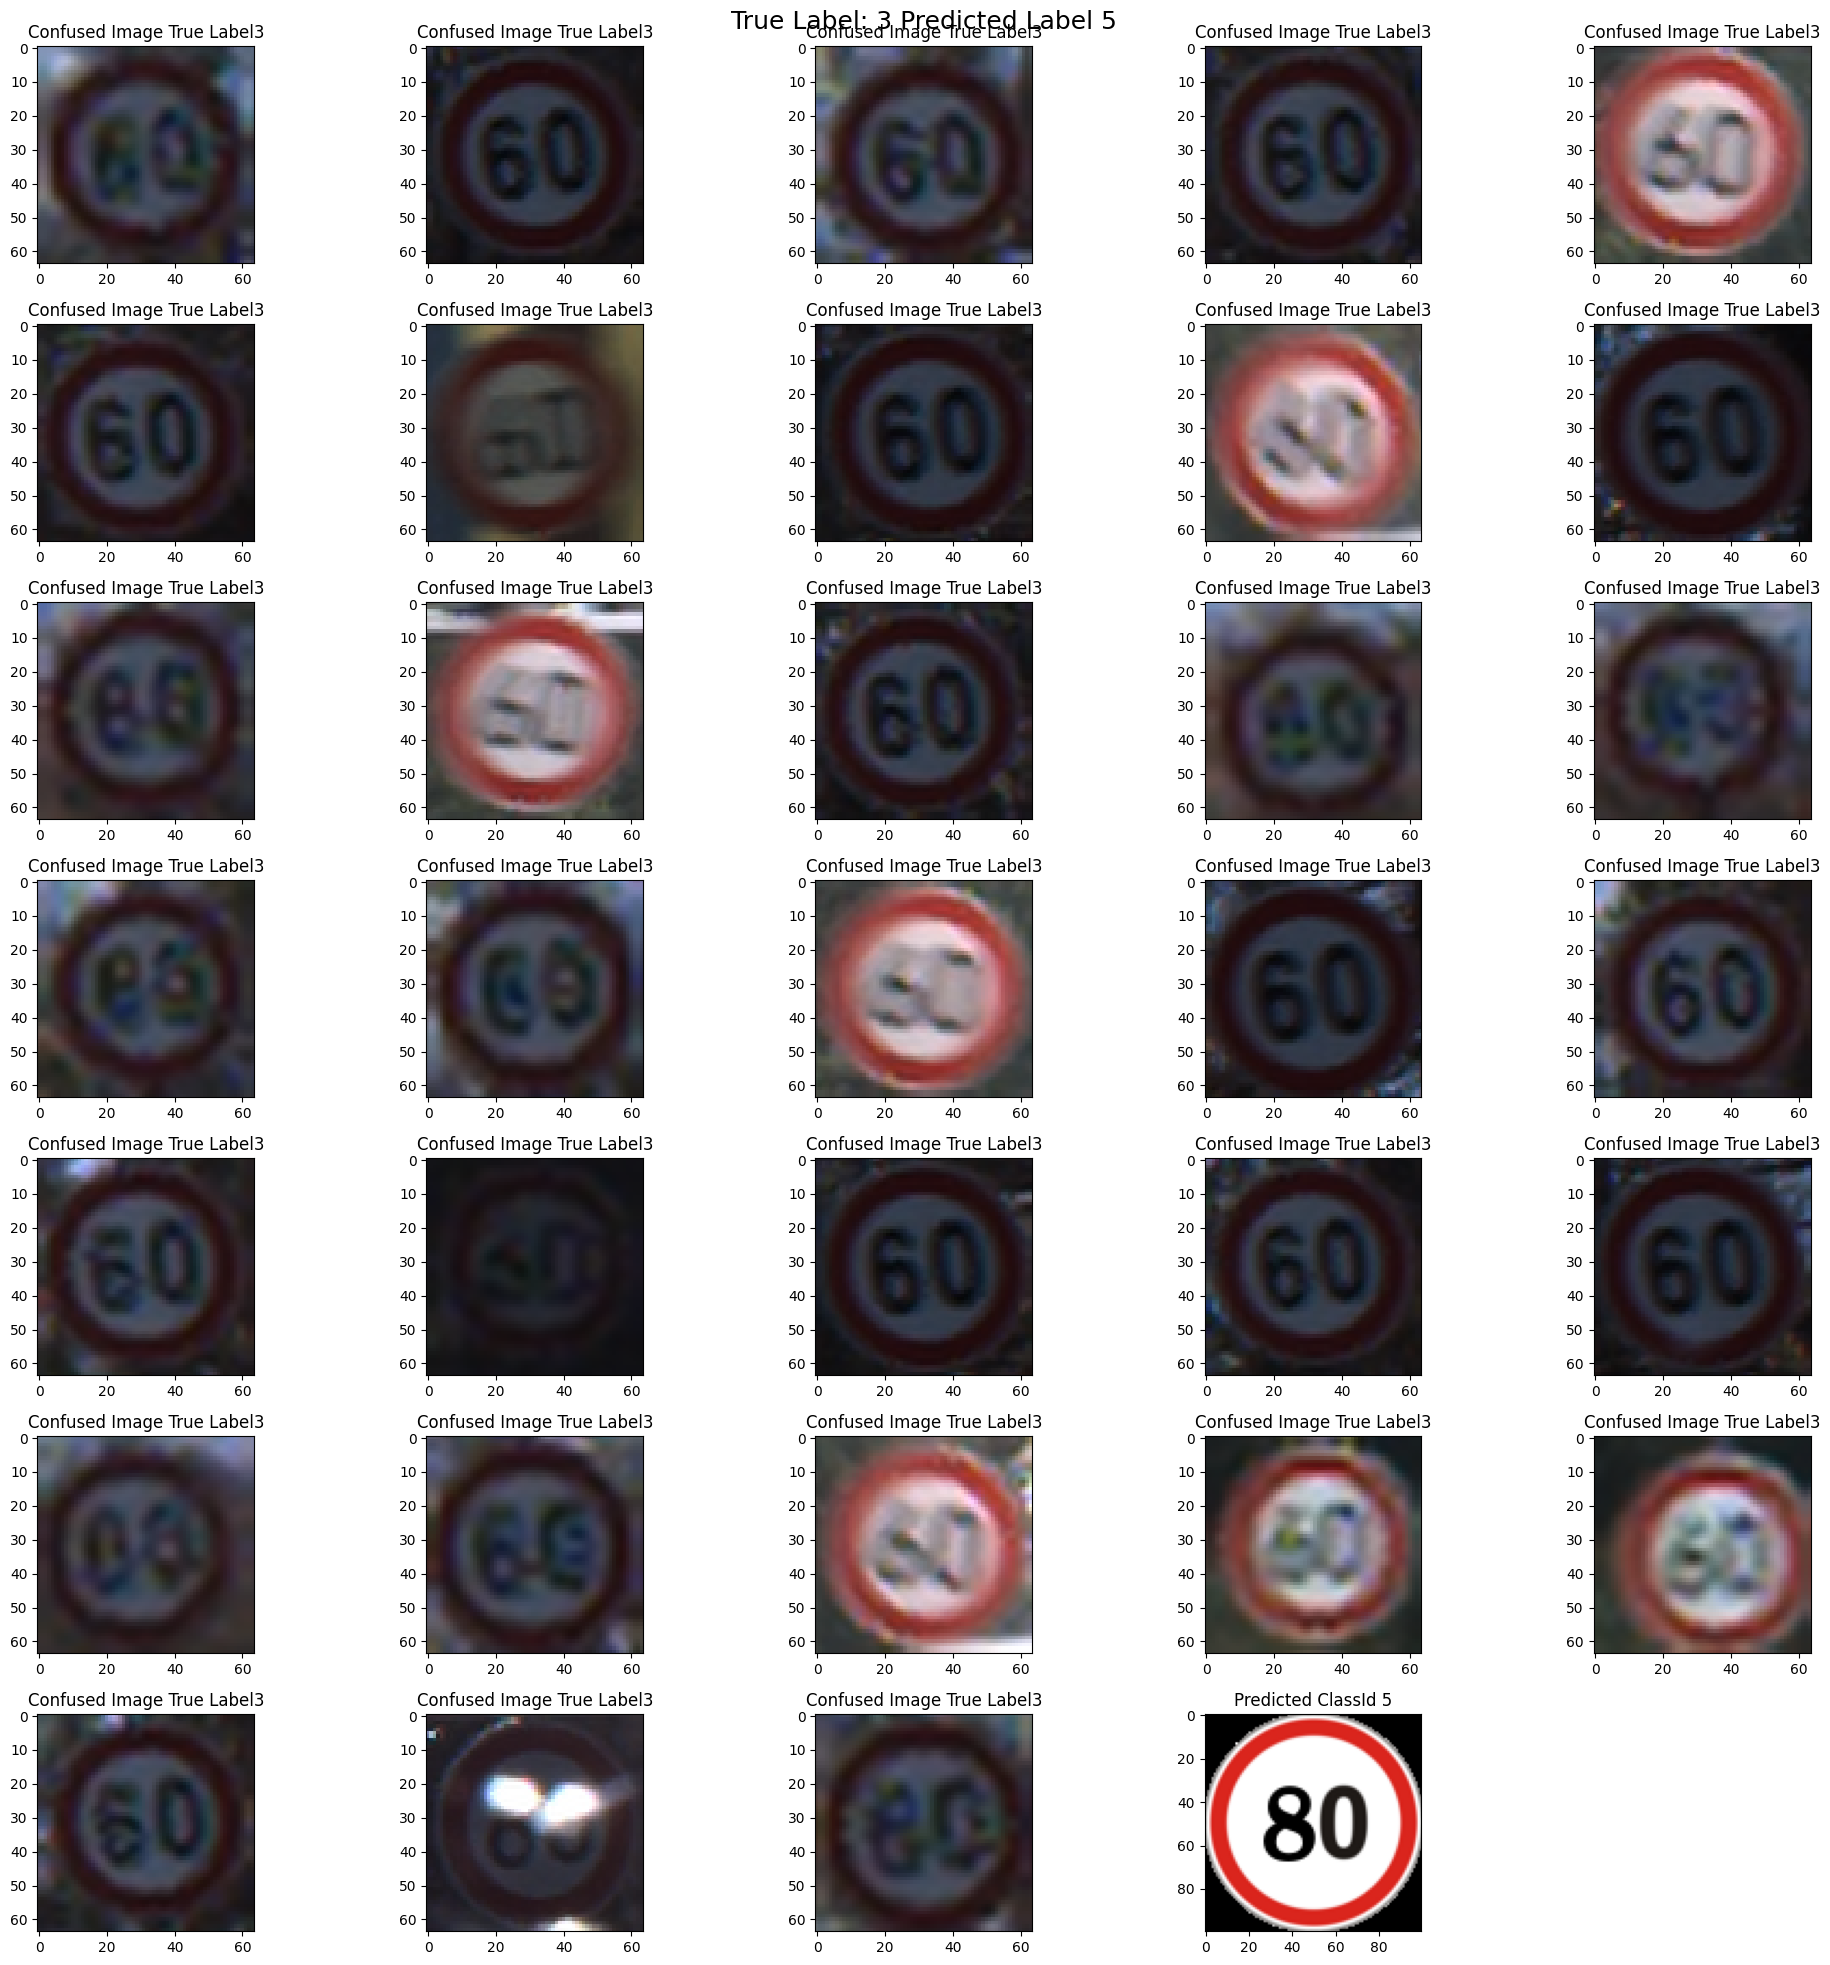

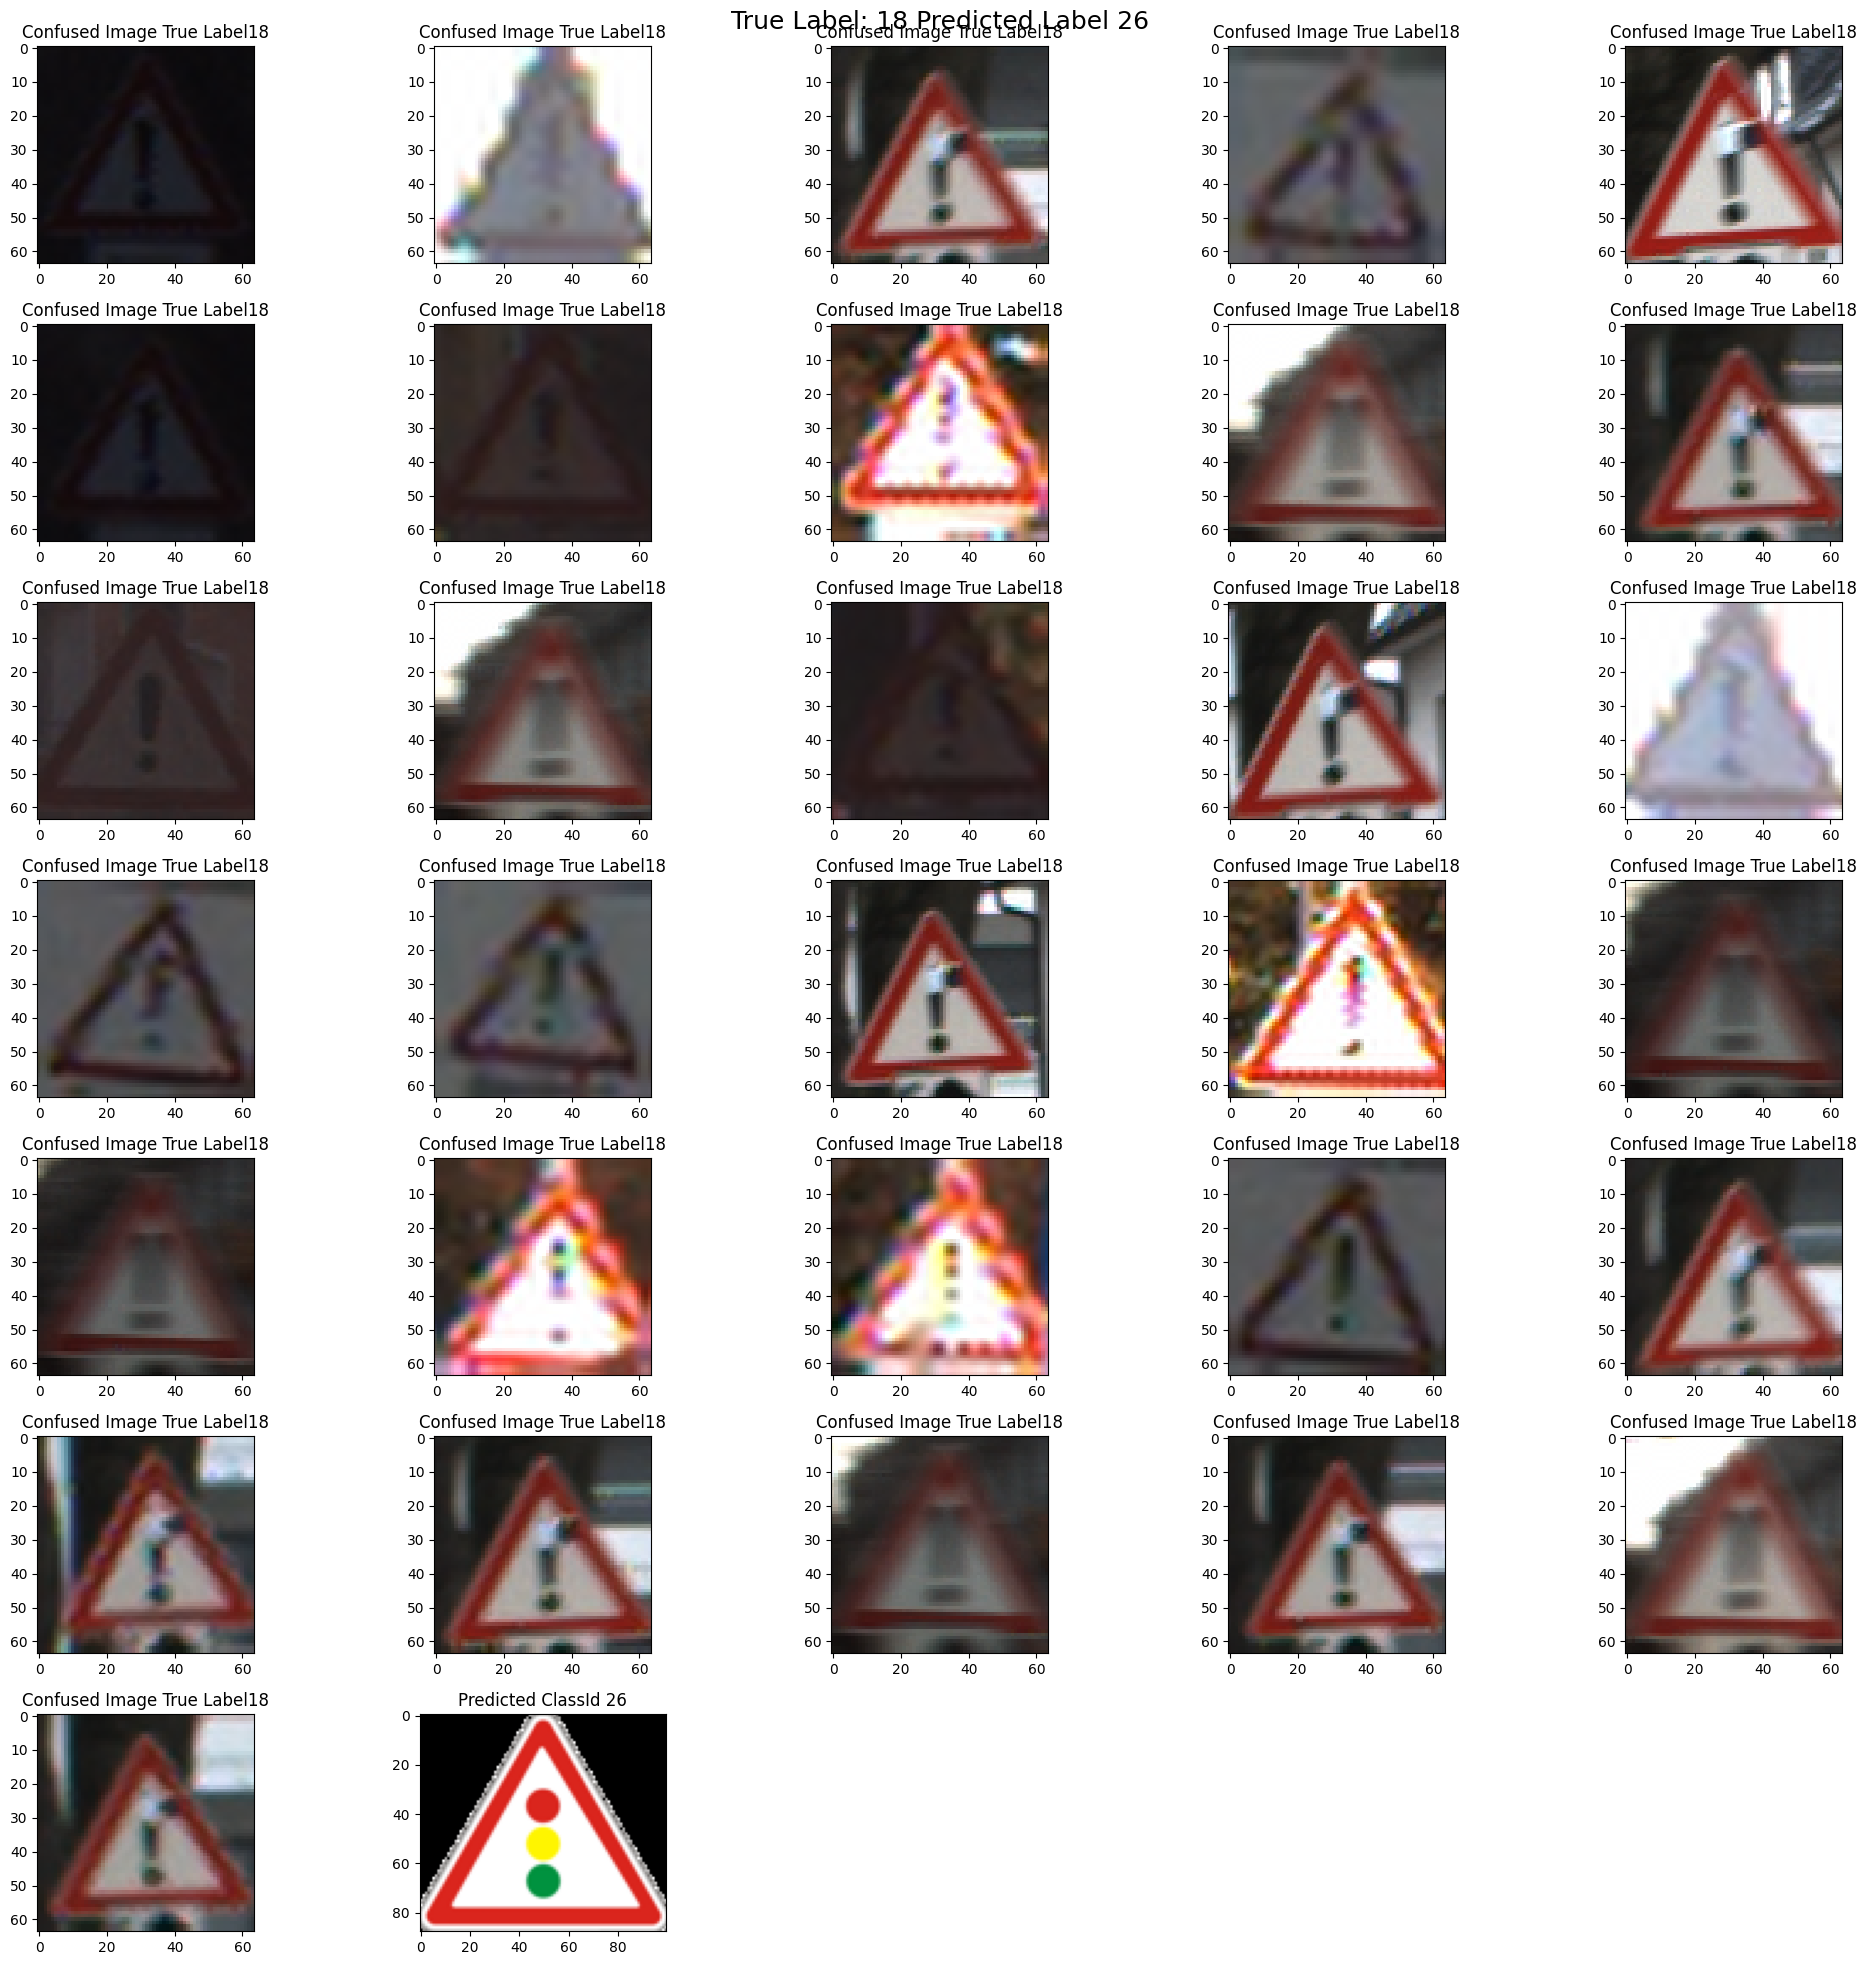

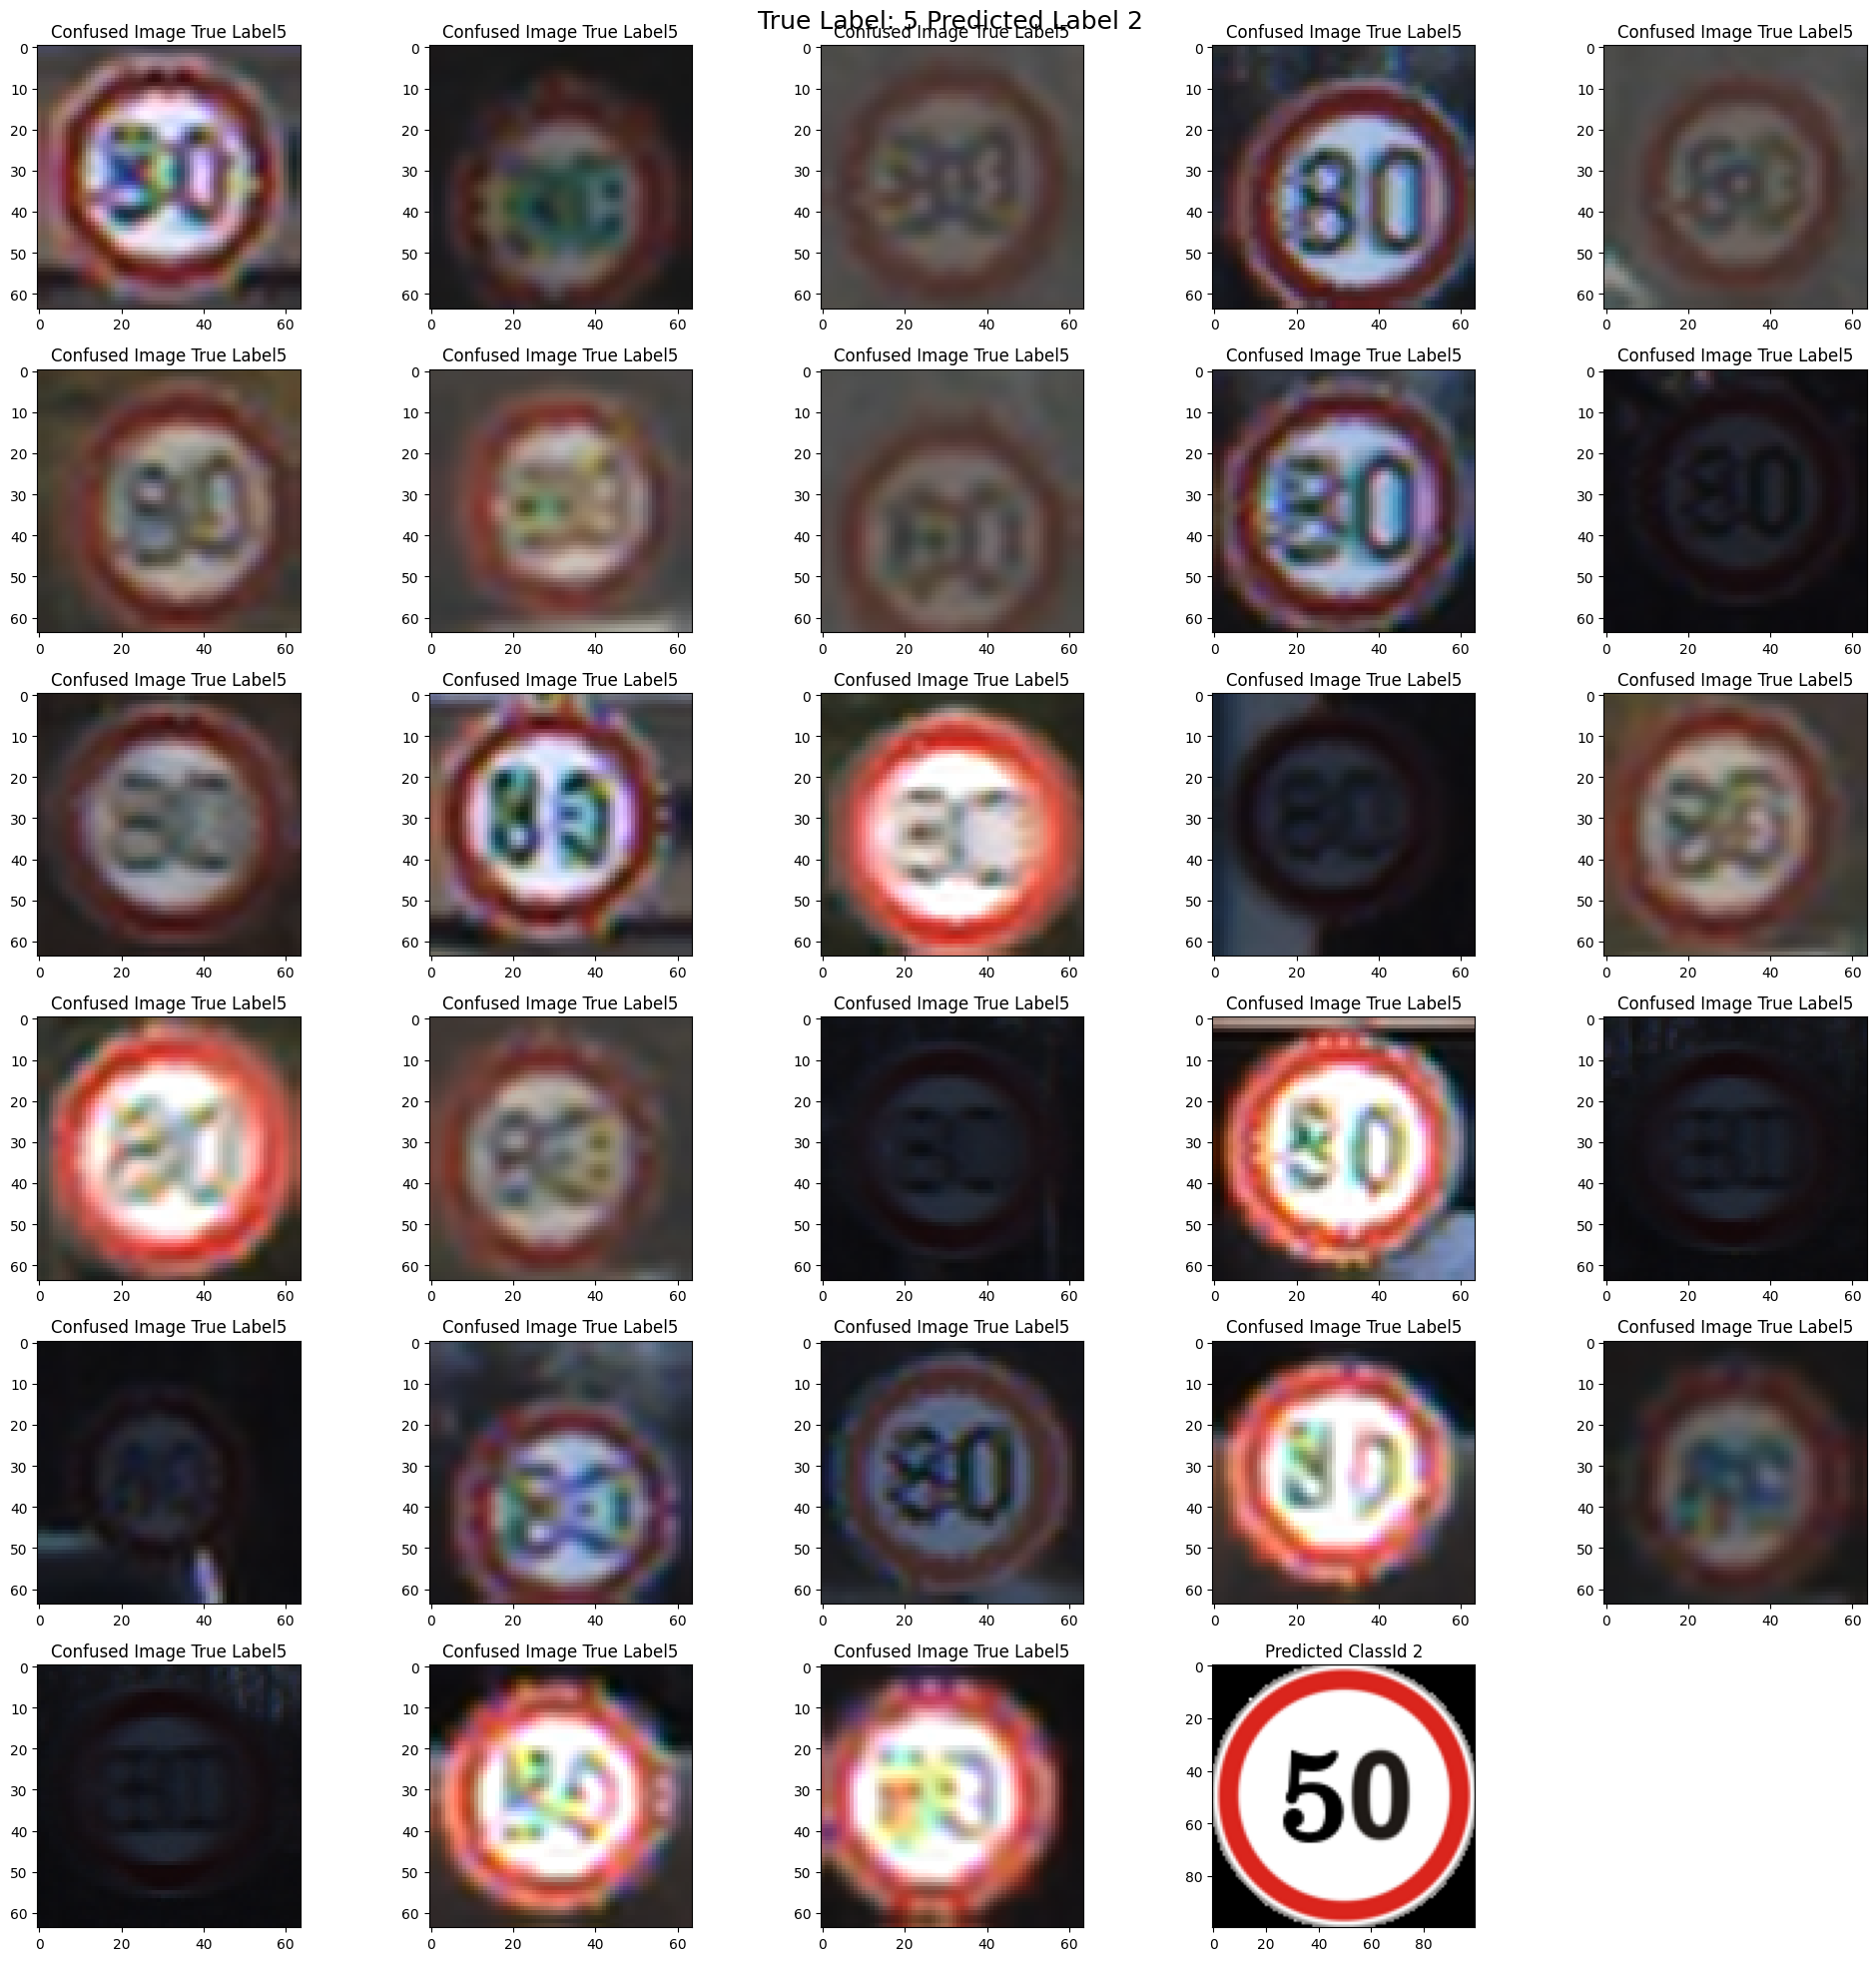

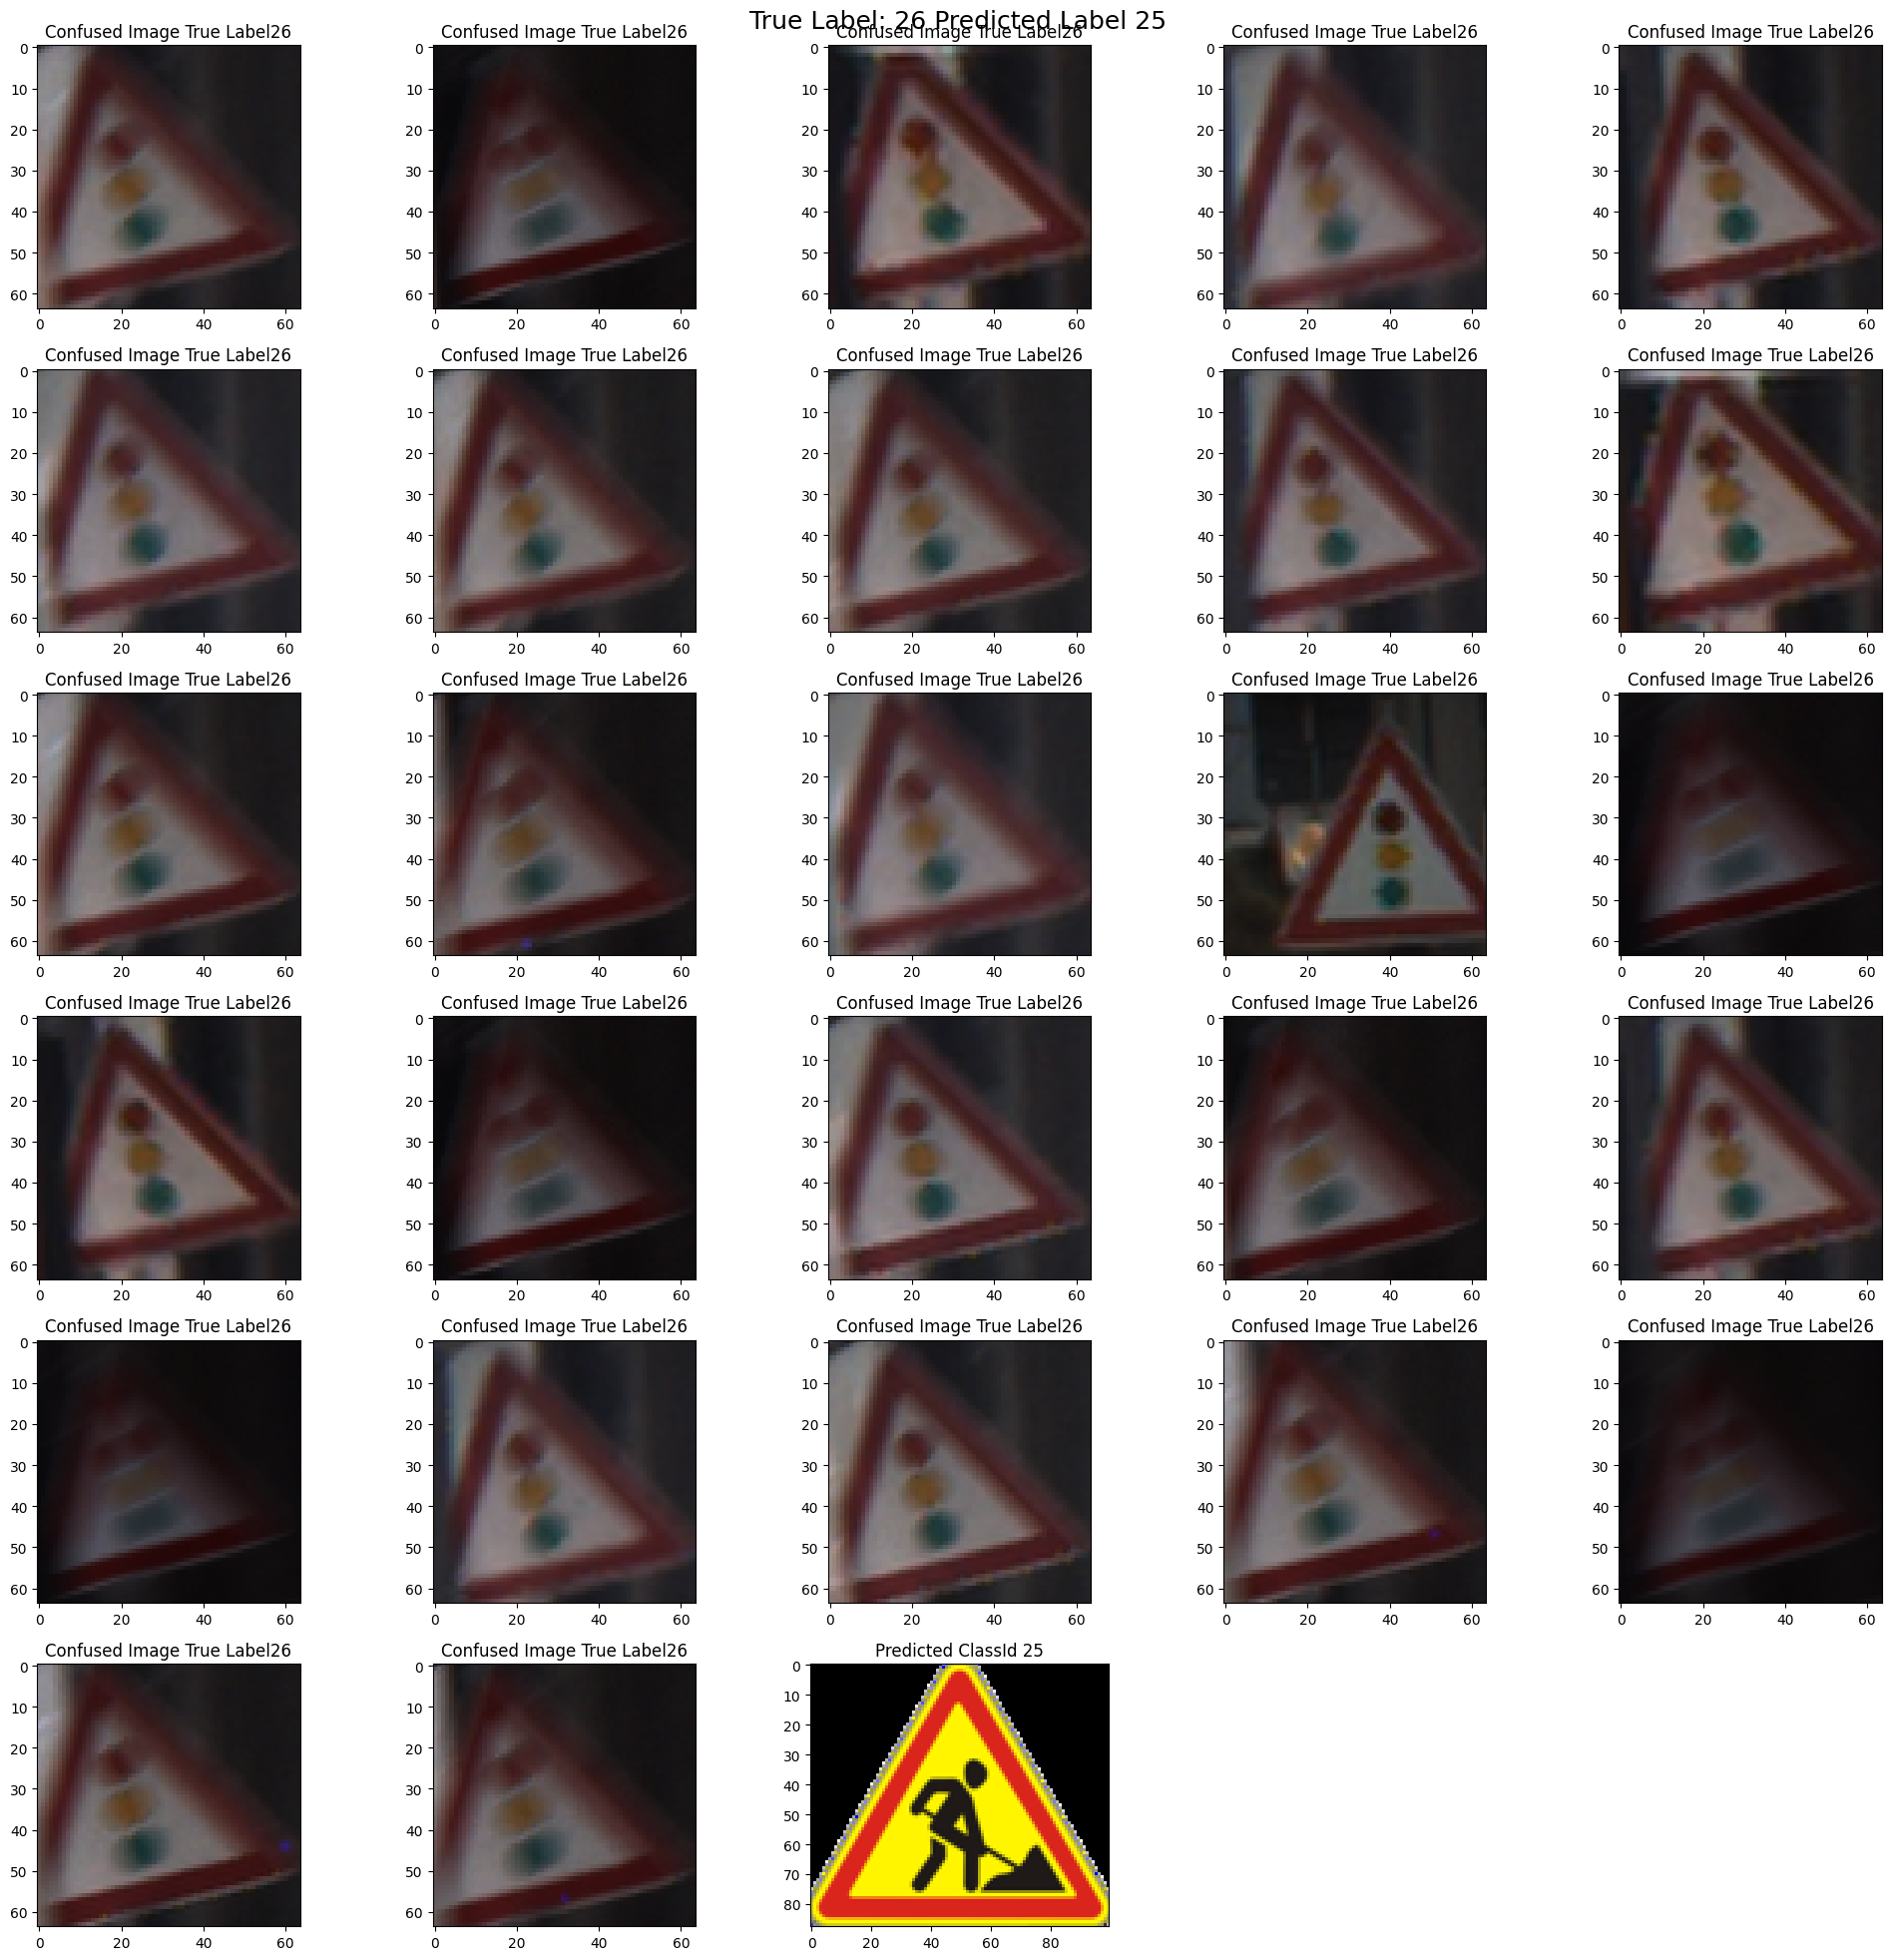

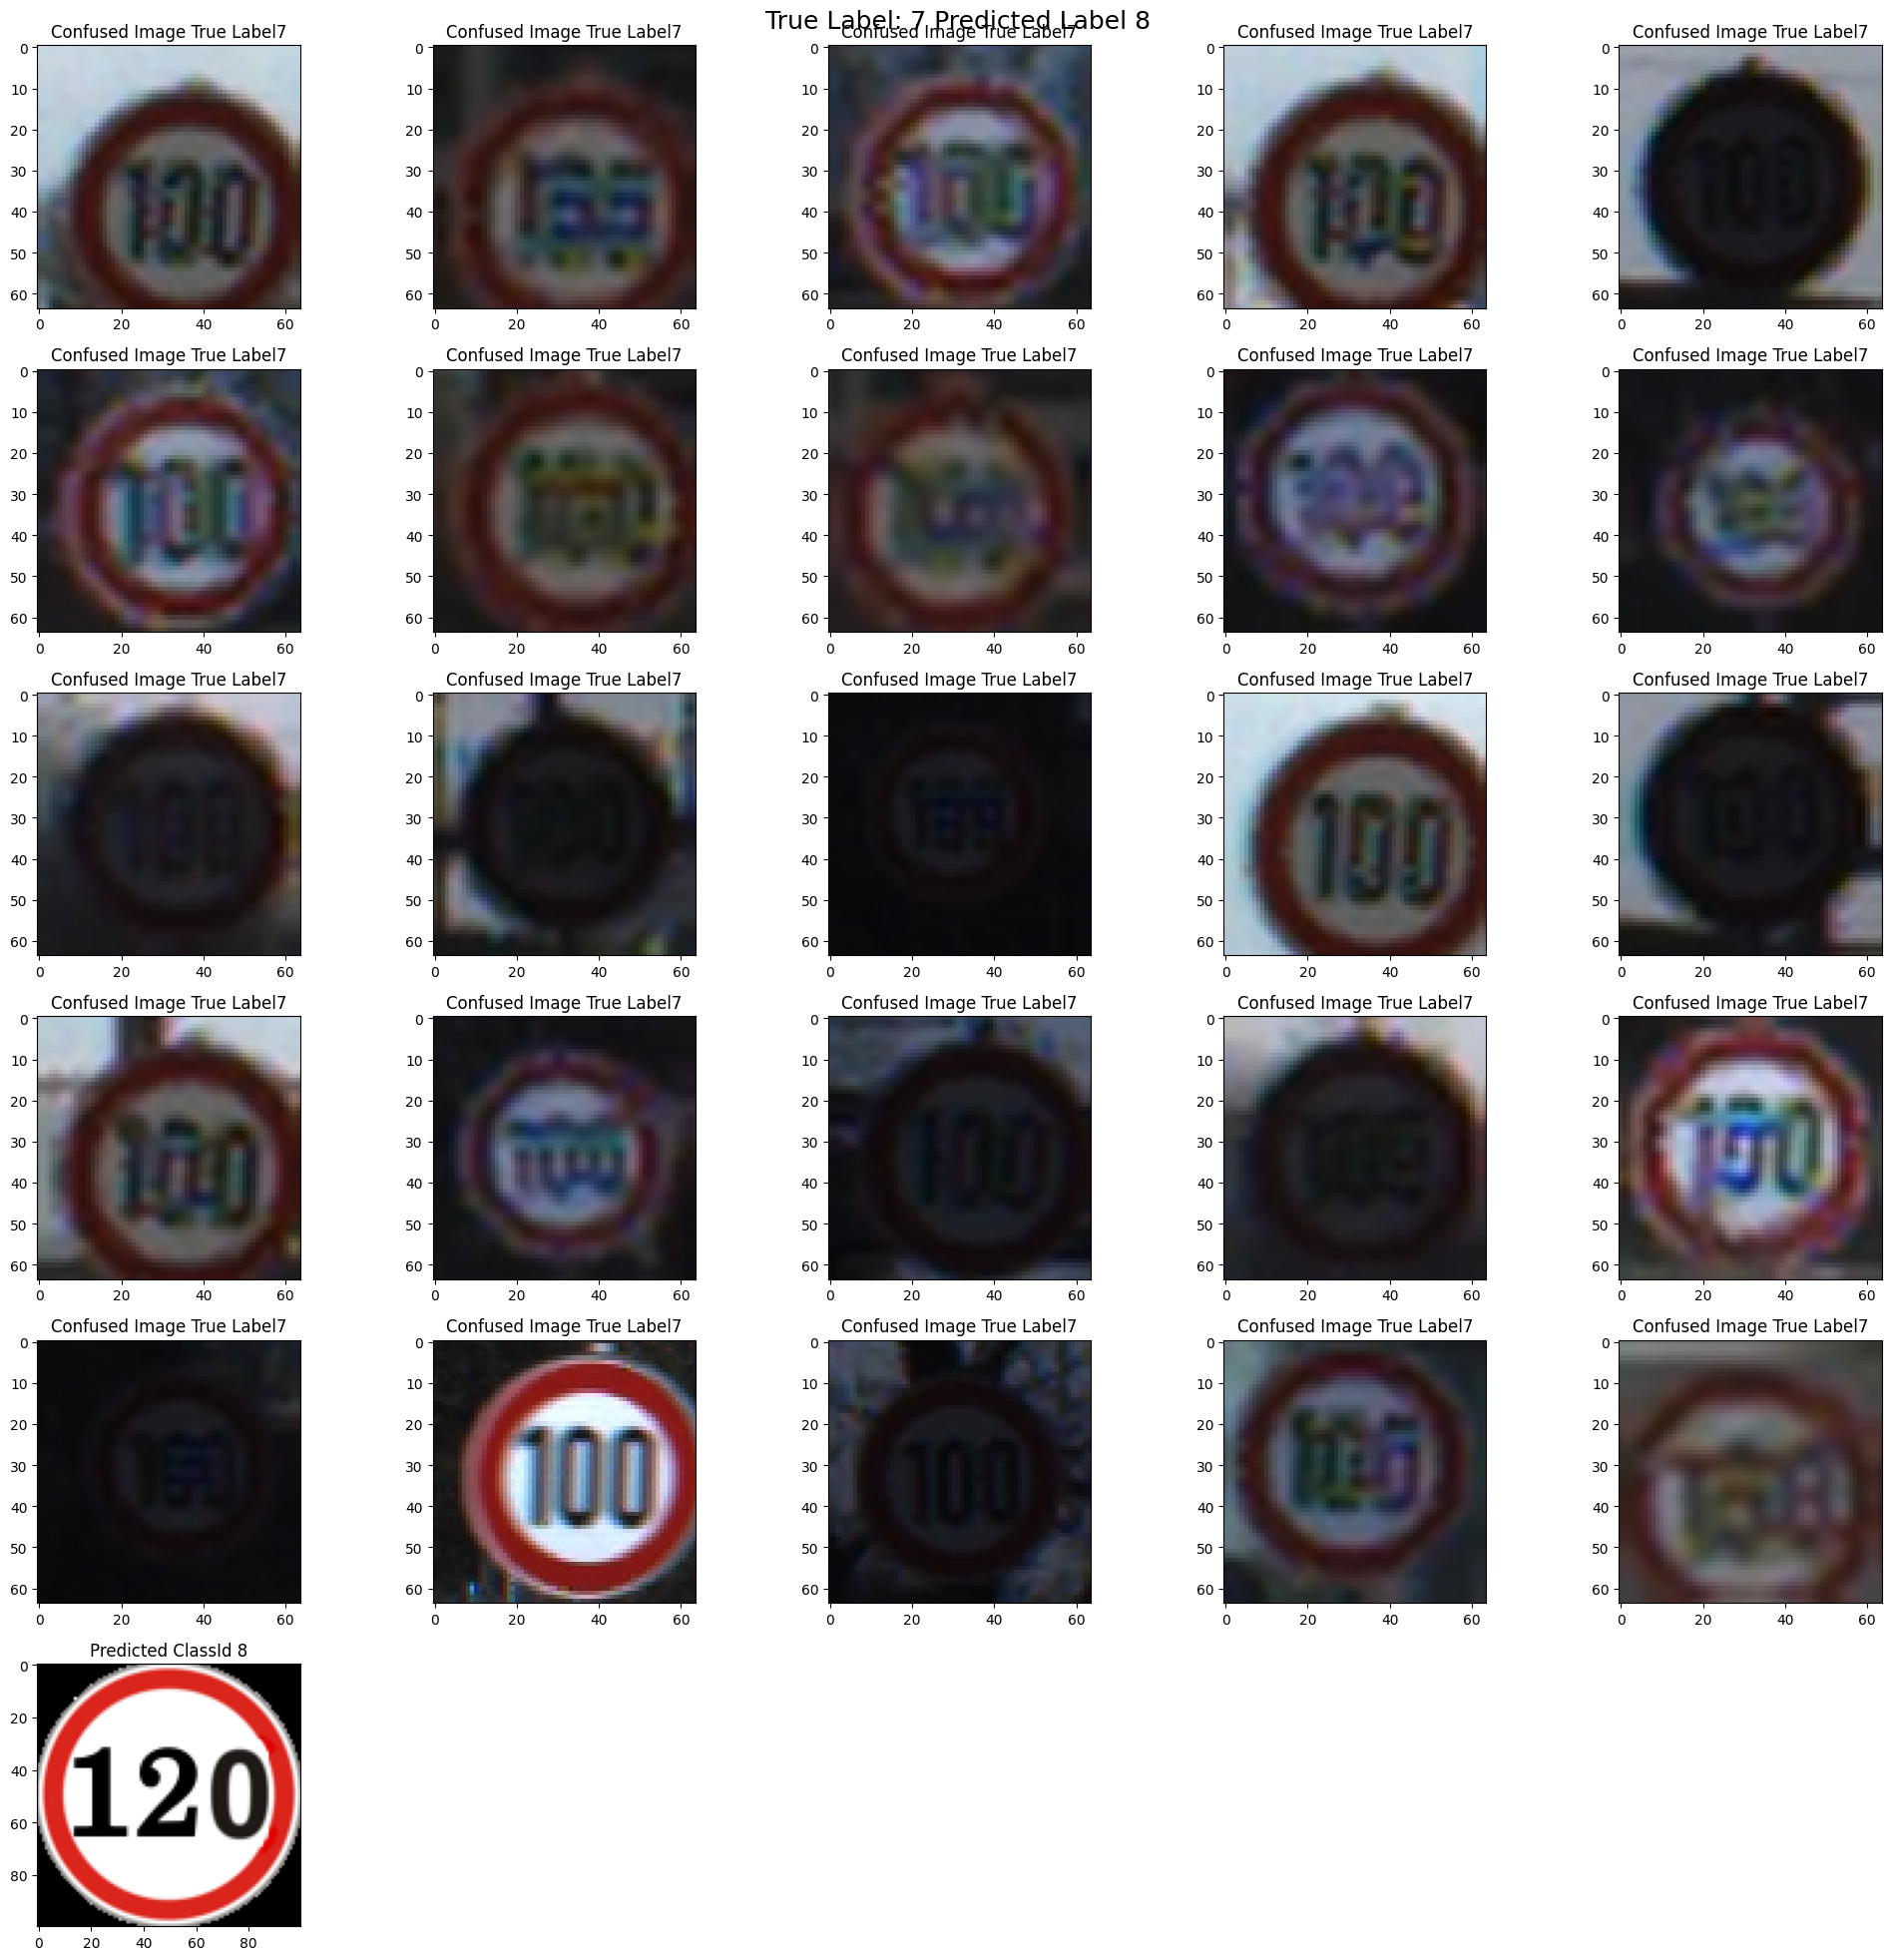

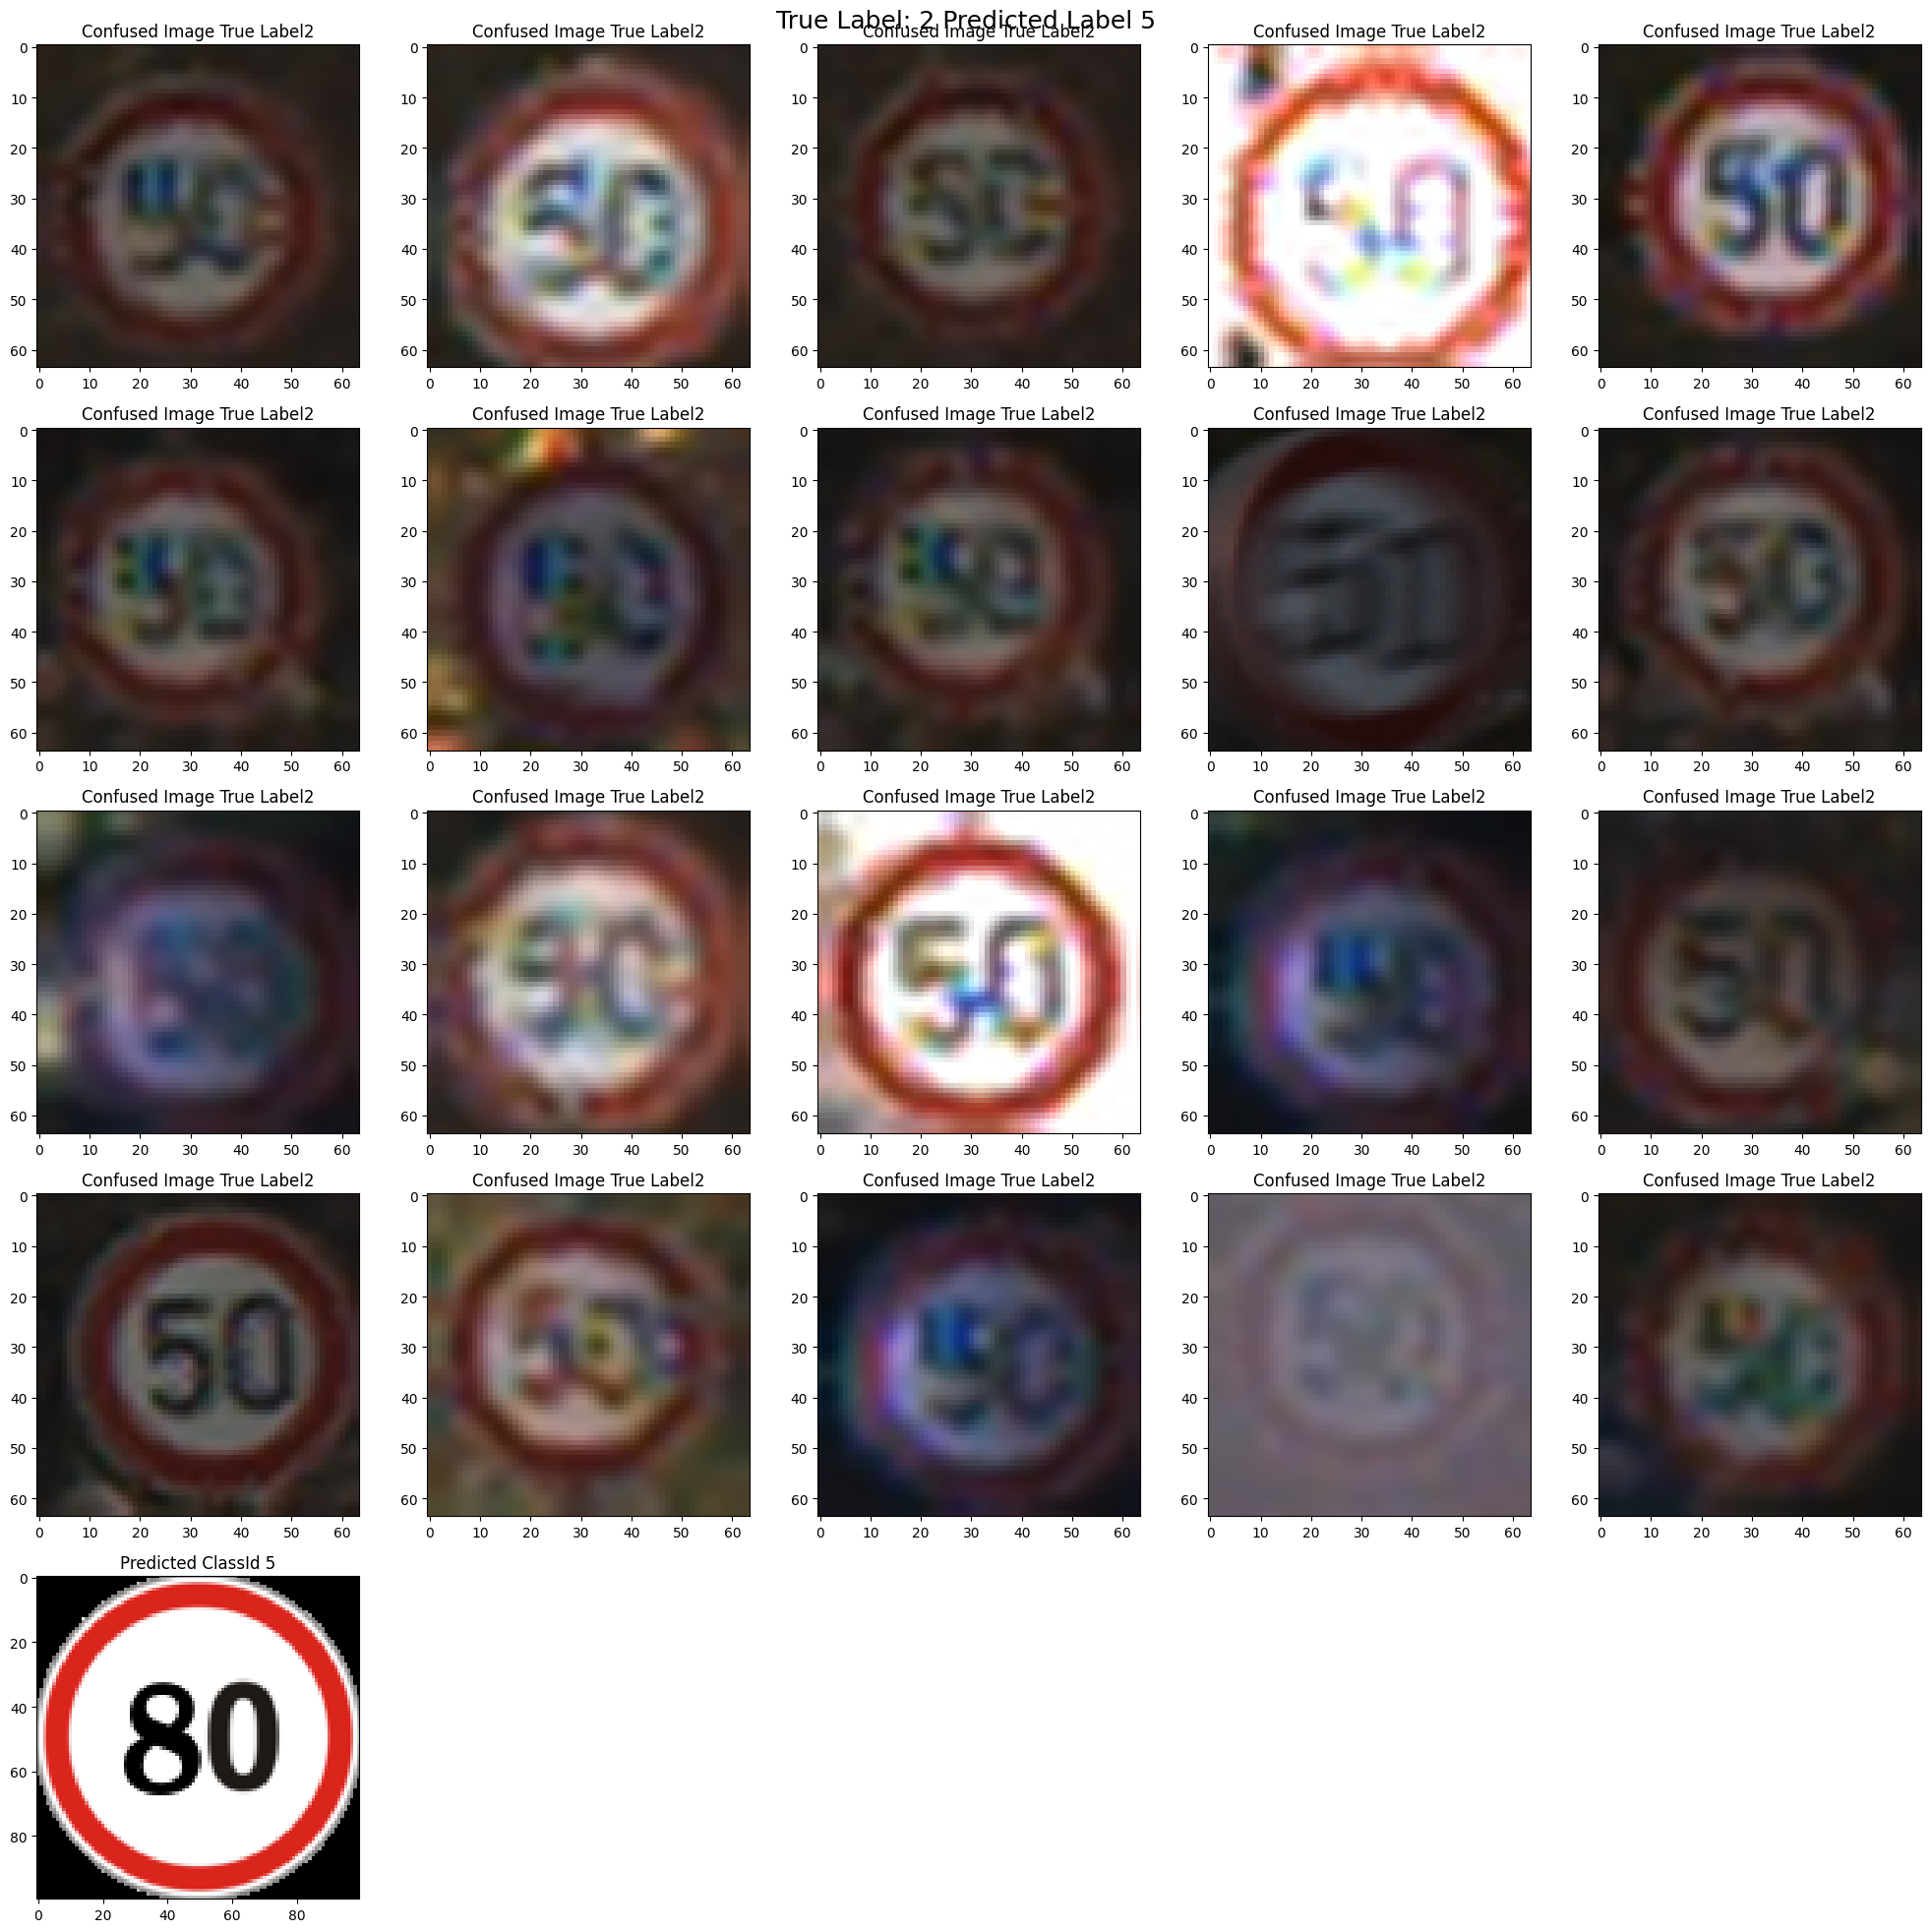

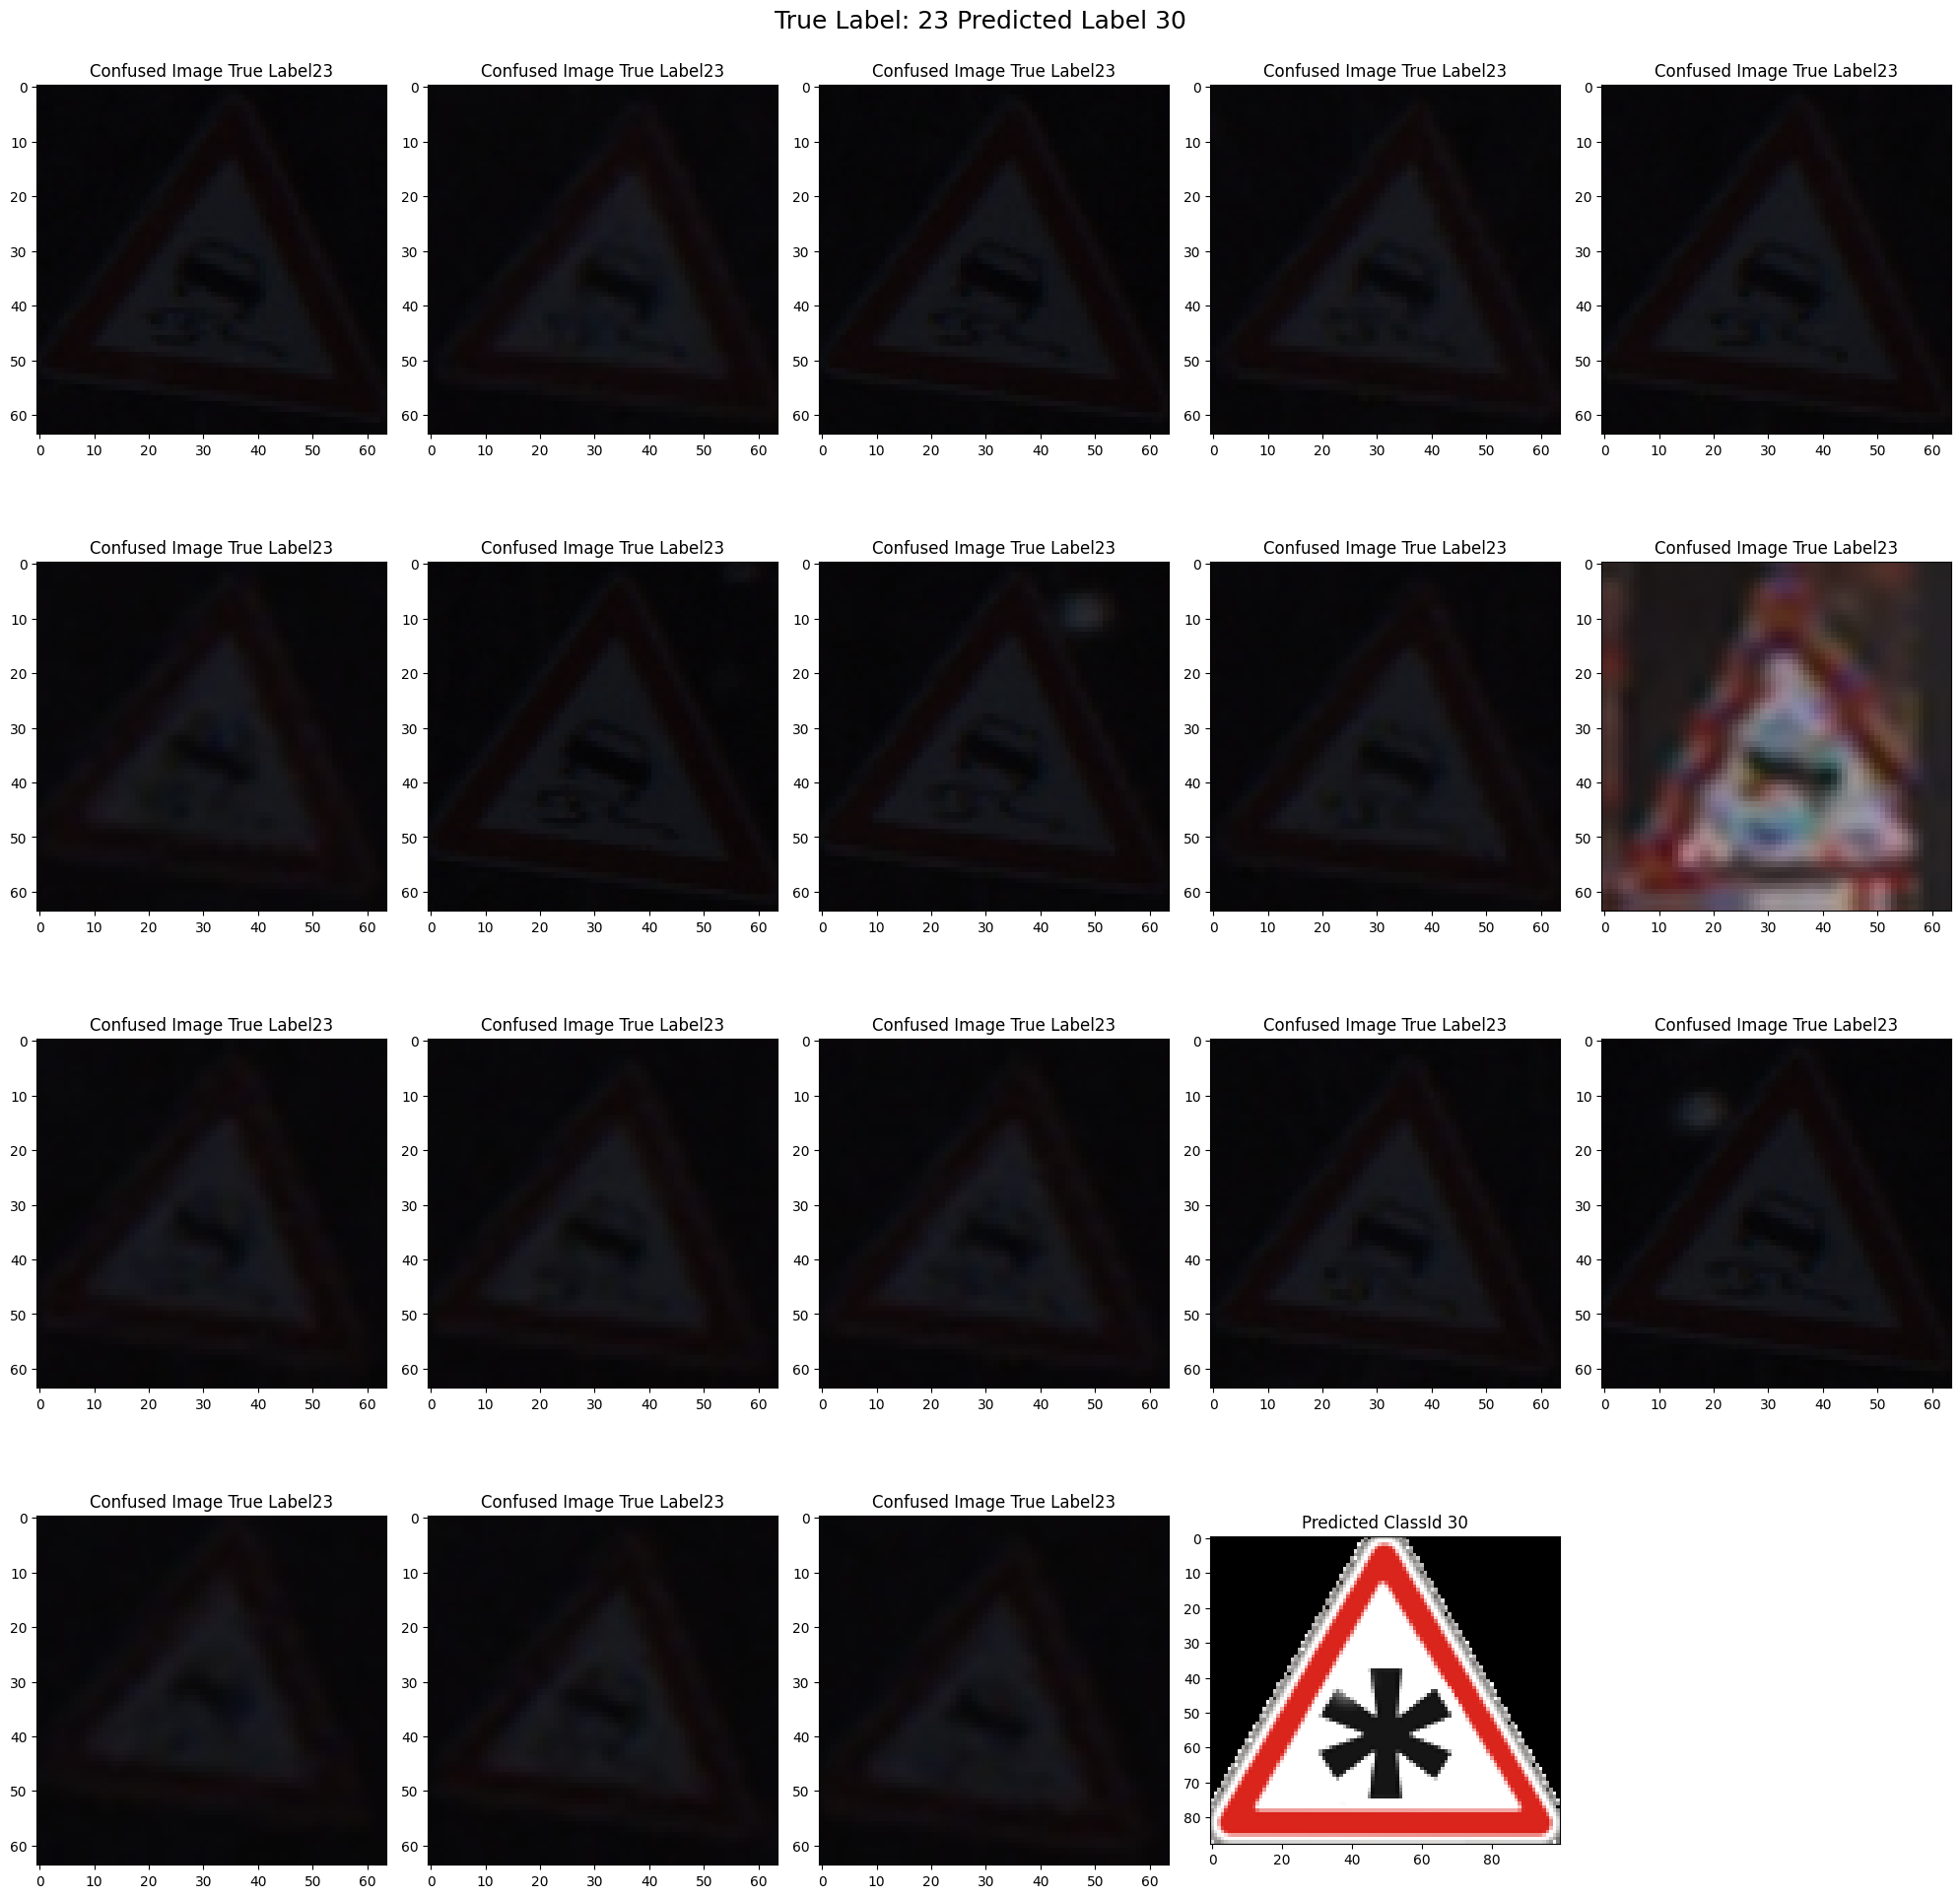

In [13]:
sorted_confused_index_dict = dict(
    sorted(confused_index_dict.items(), key=lambda x: len(x[1]), reverse=True)
)
for i, (labels, index_array) in enumerate(sorted_confused_index_dict.items()):
    images_by_confusion = []
    predicted_image = (
        np.load(
            BytesIO(meta_df.filter(meta_df["ClassId"] == labels[1])["Meta_Image"][0])
        )
        * 255.0
    ).astype(np.uint8)
    for current_image_index in index_array:
        images_by_confusion.append(
            ((np.load(BytesIO(test_df["Image"][current_image_index]))) * 255.0).astype(
                np.uint8
            )
        )

    n_row = num_rows = (len(images_by_confusion) + 1) // 5 + (
        (len(images_by_confusion) + 1) % 5 > 0
    )
    n_col = min((len(images_by_confusion) + 1), 5)
    fig = plt.figure(figsize=(20, 20))
    fig.suptitle(f"True Label: {labels[0]} Predicted Label {labels[1]}", fontsize=18)
    for j, c_image in enumerate(images_by_confusion):
        ax = fig.add_subplot(n_row, n_col, j + 1)
        ax.set_title("Confused Image True Label" + str(labels[0]))
        ax.imshow(c_image)
    ax = fig.add_subplot(n_row, n_col, j + 2)
    ax.set_title("Predicted ClassId " + str(labels[1]))
    ax.imshow(predicted_image)
    fig.tight_layout()
    plt.show()
    if i + 1 >= 10:
        break